In [1]:
# import sys
# sys.path.insert(1, './wlcstat/')
import numpy as np
# import scipy.special as sp
# import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

import itertools 
import pandas as pd

In [ ]:
DONT WANT SINGLE CHAIN, want ensembe

Impact of Conformational and Chemical Correlations on Microphase Segregation in Random Copolymers

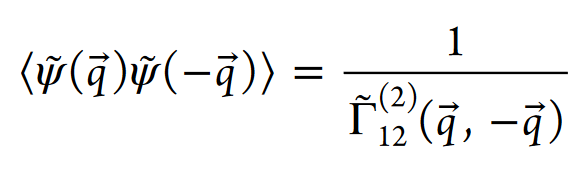

Fluctuation Effects in Semiflexible Diblock Copolymers

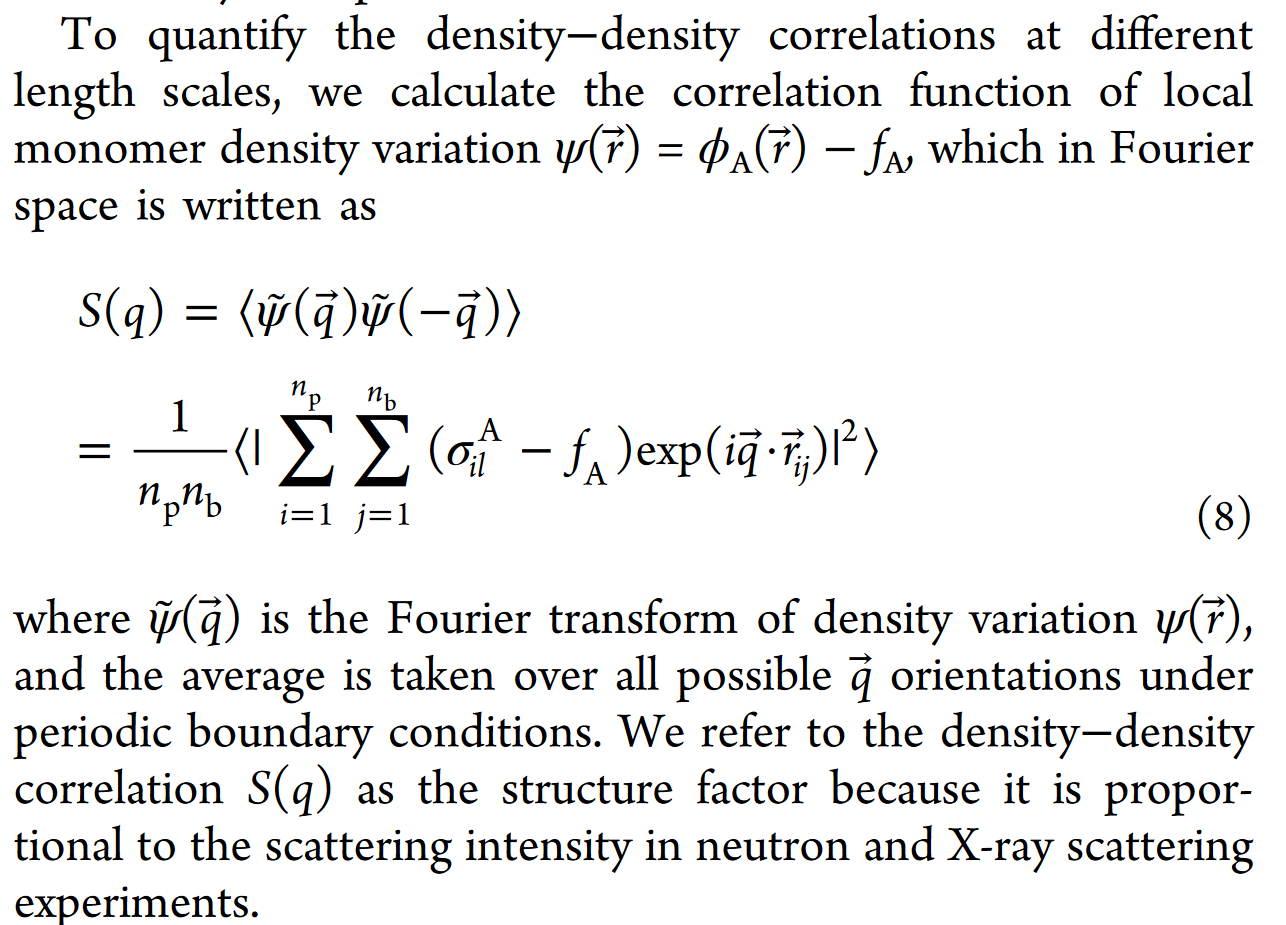

In [ ]:
TODO: This was for a melt. how to change for solution, where want A-A, A-B, B-B, A-S, B-S?
    ANSWER: just do magnitude of (sig_A - f_A)(sig_B - f_B)exp(2iqr)

## Theory

In [101]:
# ID = -5.88
ID = -13.88
looping = "nuc, "
settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],DNA,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

density_maps = np.load(r"ID=%s_density_maps.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)

In [102]:
print("v_int: ")
print(v_int)

print(r"phi_c: ")
print(phi_c)

print("mu max, min, del_mu:")
print(mu_max, mu_min, del_mu) 

print("k logspace min, max, tot num:")
print(klog_min, klog_max, klog_num)

v_int: 
[[-4  0]
 [ 0 -4]]
phi_c: 
0.4
mu max, min, del_mu:
0.1 -9 0.1
k logspace min, max, tot num:
-2.5 -1 30


first generate spinodal diagram for system at given chi. \
Then determine a subset of mu1,mu2 systems that approach spinodal. \
then analyze density-density correlations in that system

In [140]:
# stab anal
chi = 0.8
# chi = 30539.6/N

min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))
k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()
            S2_mat *= N*vol_nuc
            S2_mat[1][1] /= (N*vol_nuc)
            S2_mat[1][1] *= vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)

            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk[i][j] = minval_allk
            
            min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
            k_star_arr[i][j] = k_star
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

<Figure size 640x480 with 0 Axes>

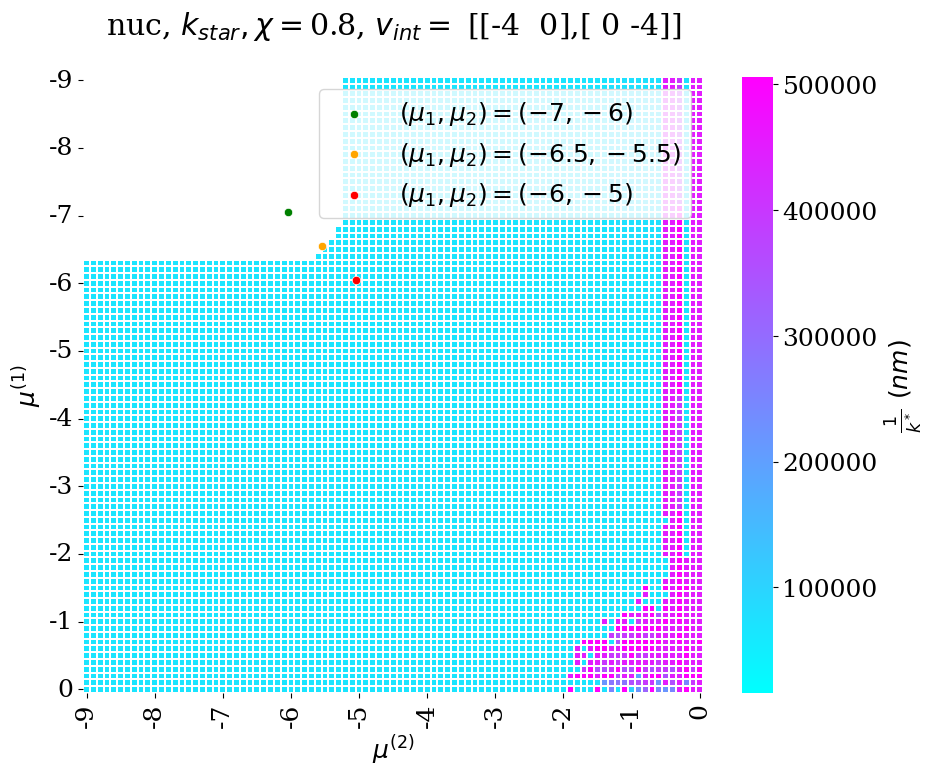

In [141]:
#density maps
# WRONG Explanation: first choose distances (in number of kuhn lengths) [or choose any length, then convert to # of kuhn lenghts]
# then invert these distances to get magnitudes of wavevectors
# then find k star, and invert it to get the critical lengthscale in units of number of kuhn lengths
# finally, (dimensional anaylsis) multiply critical lengthscale by kuhn length in nm to get lengthscale in nm!
# b*(1/(k_star_arr)

# GOOD Explanation: first choose distances. These distances must be in the same units at the persisitnece length due to exp(xm)
# term in sf calculation. Doesnt matter if used b to scale the lengths used- they are still in nanometers
# then invert these distances to get magnitudes of wavevectors
# then find k star, and invert it to get the critical lengthscale in units of nm
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

k_star_arr[np.where(np.sign(min_eigval_arr_allk) == 1) ] = np.nan
ax = sns.heatmap((1/(k_star_arr)), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array,\
                 cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"},\
                    vmin=1/(k_vec[-1]), vmax=1/(k_vec[0]))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))


# plt.plot(27.3,10.5,'go') 
sns.scatterplot(x=[30],y=[20], color = "green", label = "$(\mu_1, \mu_2) = (-7, -6)$") 
sns.scatterplot(x=[35],y=[25], color = "orange", label = "$(\mu_1, \mu_2) = (-6.5, -5.5)$") 
sns.scatterplot(x=[40],y=[30], color = "red", label = "$(\mu_1, \mu_2) = (-6, -5)$") 

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(looping + r"$ k_{star}, \chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()


In [111]:
#dens-dens analysis
mu_pnts = np.array([[-7, -6],[-6.5, -5.5], [-6, -5]])
# stab anal

g1g1_corr_arr = np.zeros((len(mu_pnts), len(k_vec)))
g1g2_corr_arr = np.zeros((len(mu_pnts), len(k_vec)))
g2g2_corr_arr = np.zeros((len(mu_pnts), len(k_vec)))

# min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

# S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

# max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
# min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))
# k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

# for i, mu1 in enumerate(mu1_array[:]):
#     for j, mu2 in enumerate(mu2_array[:]):
        
for ind, mus in enumerate(mu_pnts):
#         if mu1 == mu2:
#             continue
        mu1, mu2 = mus
        i = np.where(np.round(mu1_array, 1) == mu1)[0][0]
        j = np.where(np.round(mu2_array, 1) == mu2)[0][0]
        
        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()
            S2_mat *= N*vol_nuc
            S2_mat[1][1] /= (N*vol_nuc)
            S2_mat[1][1] *= vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)

#             S2_cond = np.linalg.cond(S2_mat)
#             S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                G2_inv = np.linalg.inv(G2)
                g1g1_corr_arr[ind, ik] = G2_inv[1,1] # g1g1
                g1g2_corr_arr[ind, ik] = G2_inv[1,2] # g1g2
                g2g2_corr_arr[ind, ik] = G2_inv[2,2] # g1g2
#                 print(G2_inv[1,2])
#                 print(G2_inv[1,1])
#                 val, vec = np.linalg.eigh(G2)
#                 vec = vec.T
#                 min_val = np.min(val)            
#                 min_eigval_arr[i][j][ik] = min_val
#                 min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

        # all-k analysis
#         min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
#         min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
#         if len(min_vals) != 0:
#             minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             min_eigval_arr_allk[i][j] = minval_allk
            
#             min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
#             k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
#             k_star_arr[i][j] = k_star
        

# setting all non-decomposed/ separated systems to 0 
# poly_fluc = min_eigvec_arr_allk[:,:,0]
# poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# prot1_fluc = min_eigvec_arr_allk[:,:,1]
# prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# prot2_fluc = min_eigvec_arr_allk[:,:,2]
# prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

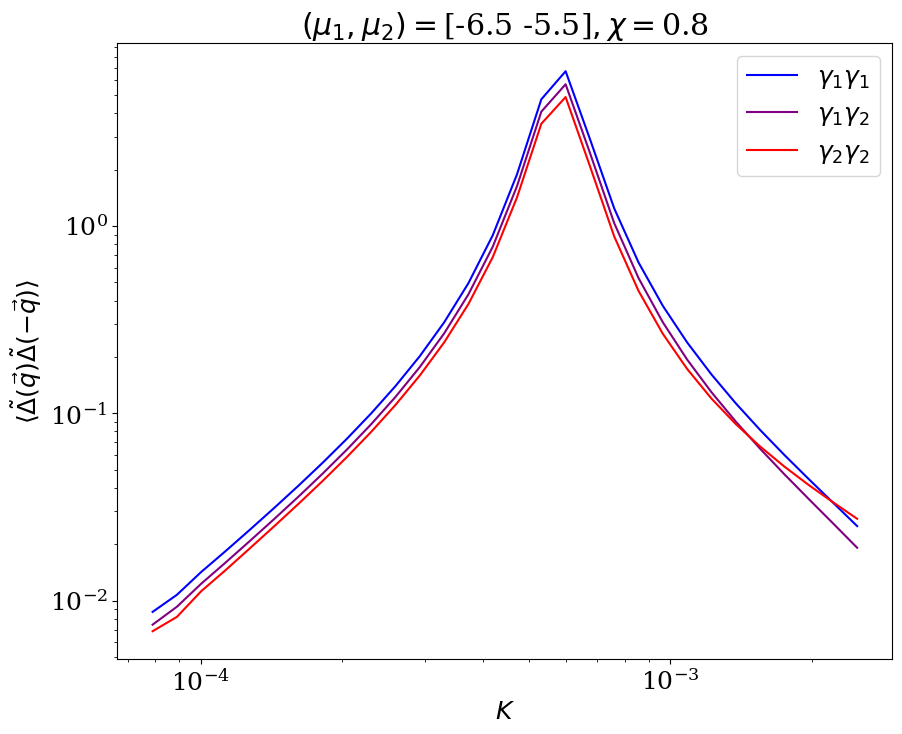

In [142]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$(\mu_1, \mu_2) =$" + str(mu_pnts[1]) + "$, \chi = $" + str(chi))
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g1_corr_arr[1], label = "$\gamma_1 \gamma_1$", color = "blue")
plt.plot(k_vec, g1g2_corr_arr[1], label = "$\gamma_1 \gamma_2$", color = "purple")
plt.plot(k_vec, g2g2_corr_arr[1], label = "$\gamma_2 \gamma_2$", color = "red")
plt.legend()
plt.xscale('log')
plt.yscale('log')

#why does it go negative in phase separated system?
# Correlation deiverges as g2 approaches 0. 
# Not physical to think about correlation past divergence, beyond just knowing that it indicates a phase separated system

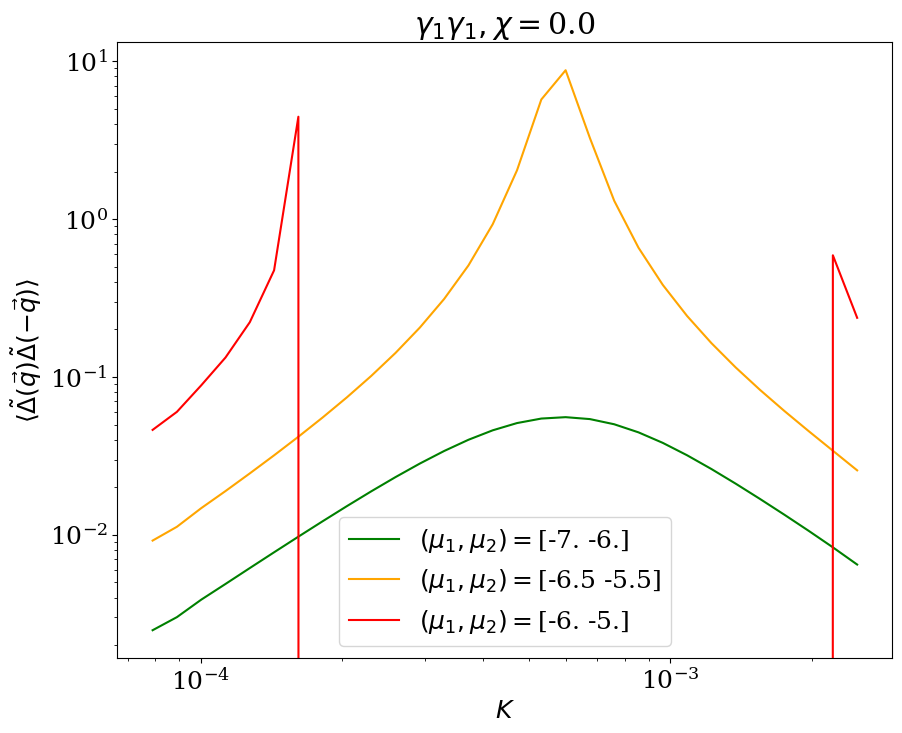

In [85]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$\gamma_1 \gamma_1, \chi = $" + str(chi))
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g1_corr_arr[0], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[0]), color = "green")
plt.plot(k_vec, g1g1_corr_arr[1], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[1]), color = "orange")
plt.plot(k_vec, g1g1_corr_arr[2], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[2]), color = "red")
plt.legend()
plt.xscale('log')
plt.yscale('log')

#why does it go negative in phase separated system?
# Correlation deiverges as g2 approaches 0. 
# Not physical to think about correlation past divergence, beyond just knowing that it indicates a phase separated system

In [164]:
1/(6e-4)

1666.6666666666667

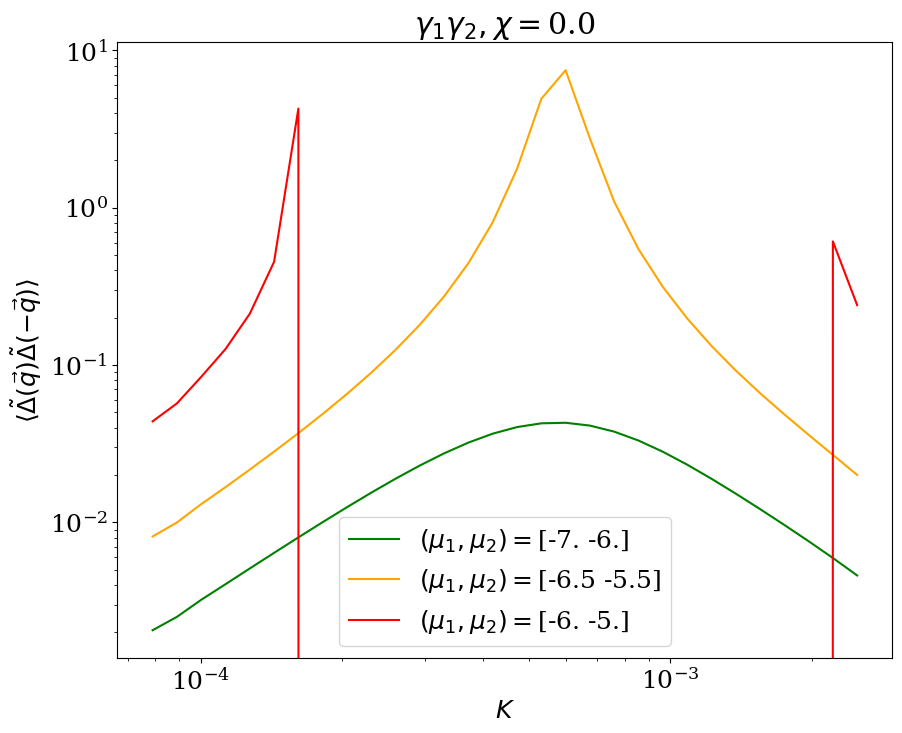

In [91]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$\gamma_1 \gamma_2, \chi = $" + str(chi))
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g2_corr_arr[0], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[0]), color = "green")
plt.plot(k_vec, g1g2_corr_arr[1], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[1]), color = "orange")
plt.plot(k_vec, g1g2_corr_arr[2], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[2]), color = "red")
plt.legend()
plt.xscale('log')
plt.yscale('log')

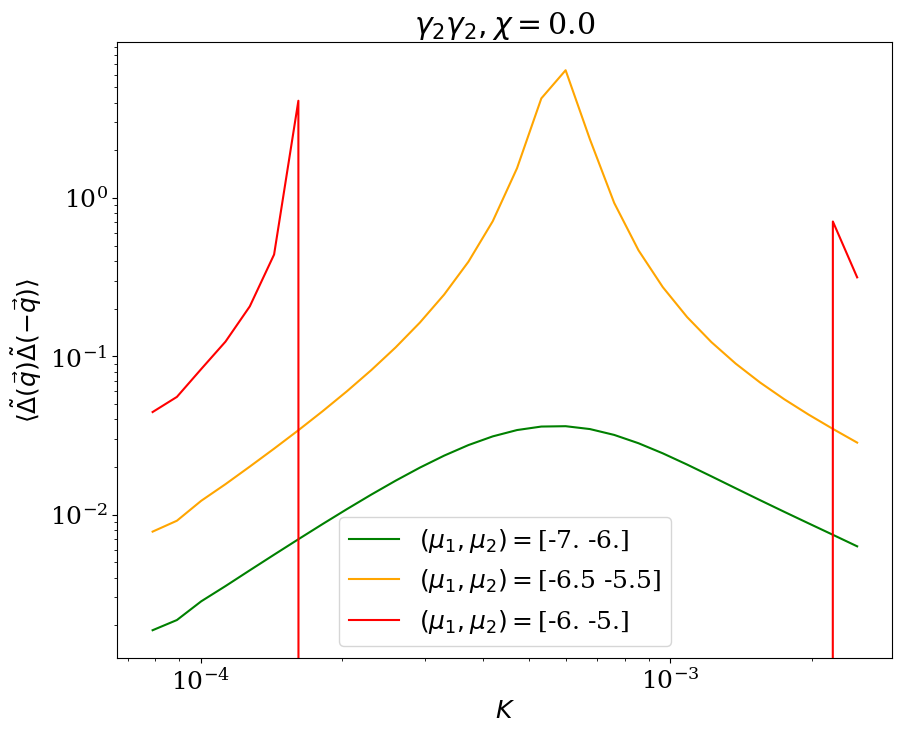

In [92]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$\gamma_2 \gamma_2, \chi = $" + str(chi))
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g2g2_corr_arr[0], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[0]), color = "green")
plt.plot(k_vec, g2g2_corr_arr[1], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[1]), color = "orange")
plt.plot(k_vec, g2g2_corr_arr[2], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[2]), color = "red")
plt.legend()
plt.xscale('log')
plt.yscale('log')

## chi comparisons

In [171]:
#dens-dens analysis
mu_pnts = np.array([[-7, -6],[-6.5, -5.5], [-6, -5]])
# stab anal

chi_0 = 0

g1g1_corr_arr_chi0 = np.zeros((len(mu_pnts), len(k_vec)))
g1g2_corr_arr_chi0 = np.zeros((len(mu_pnts), len(k_vec)))
g2g2_corr_arr_chi0 = np.zeros((len(mu_pnts), len(k_vec)))

chi_A = 0.5

g1g1_corr_arr_chiA = np.zeros((len(mu_pnts), len(k_vec)))
g1g2_corr_arr_chiA = np.zeros((len(mu_pnts), len(k_vec)))
g2g2_corr_arr_chiA = np.zeros((len(mu_pnts), len(k_vec)))

chi_B = 0.8

g1g1_corr_arr_chiB = np.zeros((len(mu_pnts), len(k_vec)))
g1g2_corr_arr_chiB = np.zeros((len(mu_pnts), len(k_vec)))
g2g2_corr_arr_chiB = np.zeros((len(mu_pnts), len(k_vec)))

# min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

# S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

# max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
# min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))
# k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

# for i, mu1 in enumerate(mu1_array[:]):
#     for j, mu2 in enumerate(mu2_array[:]):
        
for ind, mus in enumerate(mu_pnts):
#         if mu1 == mu2:
#             continue
        mu1, mu2 = mus
        i = np.where(np.round(mu1_array, 1) == mu1)[0][0]
        j = np.where(np.round(mu2_array, 1) == mu2)[0][0]
        print("mus:", mus)
        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()
            if ik ==0:
                print(S2_mat)
            S2_mat *= N*vol_nuc
            S2_mat[1][1] /= (N*vol_nuc)
            S2_mat[1][1] *= vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)

#             S2_cond = np.linalg.cond(S2_mat)
#             S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
                G2 = np.array([[S2_inv[0,0] - 2*chi_0 + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                G2_inv = np.linalg.inv(G2)
                g1g1_corr_arr_chi0[ind, ik] = G2_inv[1,1] # g1g1
                g1g2_corr_arr_chi0[ind, ik] = G2_inv[1,2] # g1g2
                g2g2_corr_arr_chi0[ind, ik] = G2_inv[2,2] # g1g2
                
                G2 = np.array([[S2_inv[0,0] - 2*chi_A + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                G2_inv = np.linalg.inv(G2)
                g1g1_corr_arr_chiA[ind, ik] = G2_inv[1,1] # g1g1
                g1g2_corr_arr_chiA[ind, ik] = G2_inv[1,2] # g1g2
                g2g2_corr_arr_chiA[ind, ik] = G2_inv[2,2] # g1g2
                
                G2 = np.array([[S2_inv[0,0] - 2*chi_B + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                G2_inv = np.linalg.inv(G2)
                g1g1_corr_arr_chiB[ind, ik] = G2_inv[1,1] # g1g1
                g1g2_corr_arr_chiB[ind, ik] = G2_inv[1,2] # g1g2
                g2g2_corr_arr_chiB[ind, ik] = G2_inv[2,2] # g1g2
#                 print(G2_inv[1,2])
#                 print(G2_inv[1,1])
#                 val, vec = np.linalg.eigh(G2)
#                 vec = vec.T
#                 min_val = np.min(val)            
#                 min_eigval_arr[i][j][ik] = min_val
#                 min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

        # all-k analysis
#         min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
#         min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
#         if len(min_vals) != 0:
#             minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             min_eigval_arr_allk[i][j] = minval_allk
            
#             min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
#             k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
#             k_star_arr[i][j] = k_star
        

# setting all non-decomposed/ separated systems to 0 
# poly_fluc = min_eigvec_arr_allk[:,:,0]
# poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# prot1_fluc = min_eigvec_arr_allk[:,:,1]
# prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# prot2_fluc = min_eigvec_arr_allk[:,:,2]
# prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

mus: [-7. -6.]
[[3.91378391e-01 0.00000000e+00 2.33204738e-03 3.25265056e-03]
 [0.00000000e+00 6.00000000e-01 0.00000000e+00 0.00000000e+00]
 [2.33204738e-03 0.00000000e+00 1.39206362e-05 1.94016393e-05]
 [3.25265056e-03 0.00000000e+00 1.94016393e-05 2.70504427e-05]]
mus: [-6.5 -5.5]
[[3.91378391e-01 0.00000000e+00 4.25440121e-03 6.04831704e-03]
 [0.00000000e+00 6.00000000e-01 0.00000000e+00 0.00000000e+00]
 [4.25440121e-03 0.00000000e+00 4.63348737e-05 6.58243830e-05]
 [6.04831704e-03 0.00000000e+00 6.58243830e-05 9.35441126e-05]]
mus: [-6. -5.]
[[3.91378391e-01 0.00000000e+00 8.17146685e-03 1.19071172e-02]
 [0.00000000e+00 6.00000000e-01 0.00000000e+00 0.00000000e+00]
 [8.17146685e-03 0.00000000e+00 1.70959624e-04 2.48931857e-04]
 [1.19071172e-02 0.00000000e+00 2.48931857e-04 3.62590574e-04]]


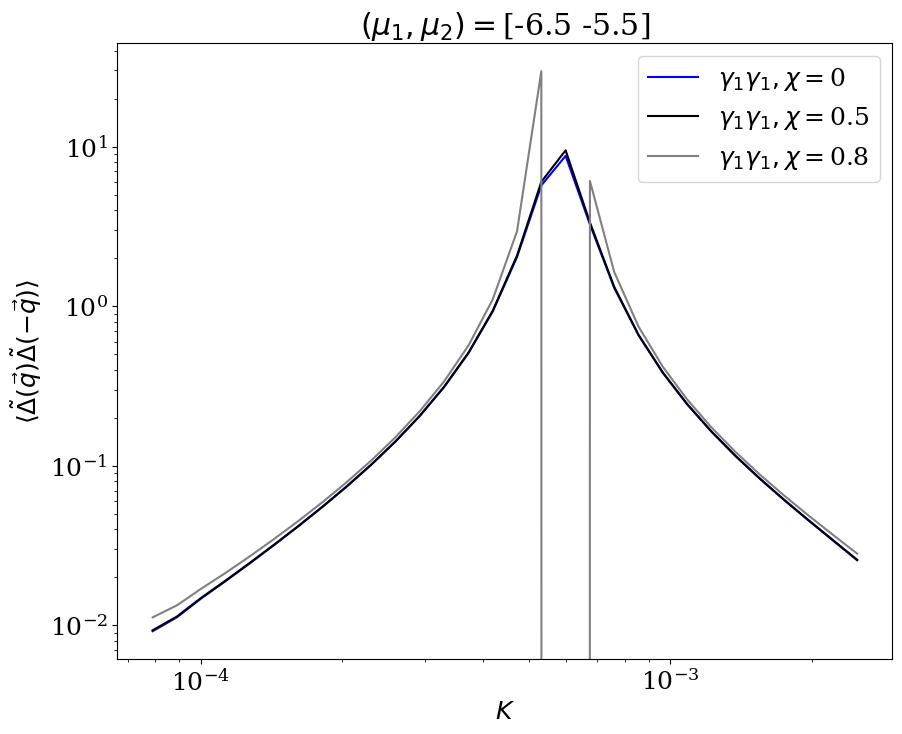

In [139]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$(\mu_1, \mu_2) =$" + str(mu_pnts[1]) )
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g1_corr_arr_chi0[1], label = "$\gamma_1 \gamma_1, \chi = $" + str(chi_0), color = "blue")
# plt.plot(k_vec, g1g2_corr_arr_chi0[1], label = "$\gamma_1 \gamma_2, \chi = $"+ str(chi_0), color = "purple")
# plt.plot(k_vec, g2g2_corr_arr_chi0[1], label = "$\gamma_2 \gamma_2, \chi = $"+ str(chi_0), color = "red")

plt.plot(k_vec, g1g1_corr_arr_chiA[1], label = "$\gamma_1 \gamma_1, \chi = $" + str(chi_A), color = "black")
# plt.plot(k_vec, g1g2_corr_arr_chiA[1], label = "$\gamma_1 \gamma_2, \chi = $" + str(chi_A), color = "grey")

plt.plot(k_vec, g1g1_corr_arr_chiB[1], label = "$\gamma_1 \gamma_1, \chi = $" + str(chi_B), color = "grey")

plt.legend()
plt.xscale('log')
plt.yscale('log')

#why does it go negative in phase separated system?
# Correlation deiverges as g2 approaches 0. 
# Not physical to think about correlation past divergence, beyond just knowing that it indicates a phase separated system

## HP1 only, binding on

In [76]:
# ID = -5.88
ID = -13.88
looping = "nuc, "
settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],DNA,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

density_maps = np.load(r"ID=%s_density_maps.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)

In [77]:
print("v_int: ")
print(v_int)

print(r"phi_c: ")
print(phi_c)

print("mu max, min, del_mu:")
print(mu_max, mu_min, del_mu) 

print("k logspace min, max, tot num:")
print(klog_min, klog_max, klog_num)

v_int: 
[[-4  0]
 [ 0 -4]]
phi_c: 
0.4
mu max, min, del_mu:
0.1 -9 0.1
k logspace min, max, tot num:
-2.5 -1 30


In [78]:
#dens-dens analysis
mu_pnts = np.array([[-8, -6],[-7, -6],[-6, -6],[-6.5, -6], [-6, -6]])
# stab anal

g1g1_corr_arr_chi_A = np.zeros((len(mu_pnts), len(k_vec)))
# g1g2_corr_arr = np.zeros((len(mu_pnts), len(k_vec)))
# g2g2_corr_arr = np.zeros((len(mu_pnts), len(k_vec)))

# min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

# S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

# max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
# min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))
# k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

chi_A = -1
# for i, mu1 in enumerate(mu1_array[:]):
#     for j, mu2 in enumerate(mu2_array[:]):
        
for ind, mus in enumerate(mu_pnts):
#         if mu1 == mu2:
#             continue
        mu1, mu2 = mus
        i = np.where(np.round(mu1_array, 1) == mu1)[0][0]
        j = np.where(np.round(mu2_array, 1) == mu2)[0][0]
        
        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
#                 S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0]],\
#                         [0, ss*N**2, 0], \
#                         [cg1[0], 0, g1g1[0]] ])
    
            S2_mat =  s2_mats[i][j][ik].copy()
#             print(S2_mat)
            S2_mat = S2_mat[:3, :3] # dropping PRC1 terms
#             print(S2_mat)
            S2_mat *= N*vol_nuc
            S2_mat[1][1] /= (N*vol_nuc)
            S2_mat[1][1] *= vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # 1 reader proteins
            S2_det = np.linalg.det(S2_mat)

#             S2_cond = np.linalg.cond(S2_mat)
#             S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
#                 G2_inv = np.linalg.inv(G2)
#                 g1g1_corr_arr[ind, ik] = G2_inv[1,1] # g1g1
                
                G2 = np.array([[S2_inv[0,0] - 2*chi_A + S2_inv[1,1], S2_inv[0,2] ],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0] ]] )

                G2_inv = np.linalg.inv(G2)
                g1g1_corr_arr_chi_A[ind, ik] = G2_inv[1,1] # g1g1
                
        #                 g1g2_corr_arr[ind, ik] = G2_inv[1,2] # g1g2
#                 g2g2_corr_arr[ind, ik] = G2_inv[2,2] # g1g2
#                 print(G2_inv[1,2])
#                 print(G2_inv[1,1])
#                 val, vec = np.linalg.eigh(G2)
#                 vec = vec.T
#                 min_val = np.min(val)            
#                 min_eigval_arr[i][j][ik] = min_val
#                 min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

        # all-k analysis
#         min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
#         min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
#         if len(min_vals) != 0:
#             minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             min_eigval_arr_allk[i][j] = minval_allk
            
#             min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
#             k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
#             k_star_arr[i][j] = k_star
        

# setting all non-decomposed/ separated systems to 0 
# poly_fluc = min_eigvec_arr_allk[:,:,0]
# poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# prot1_fluc = min_eigvec_arr_allk[:,:,1]
# prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# prot2_fluc = min_eigvec_arr_allk[:,:,2]
# prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

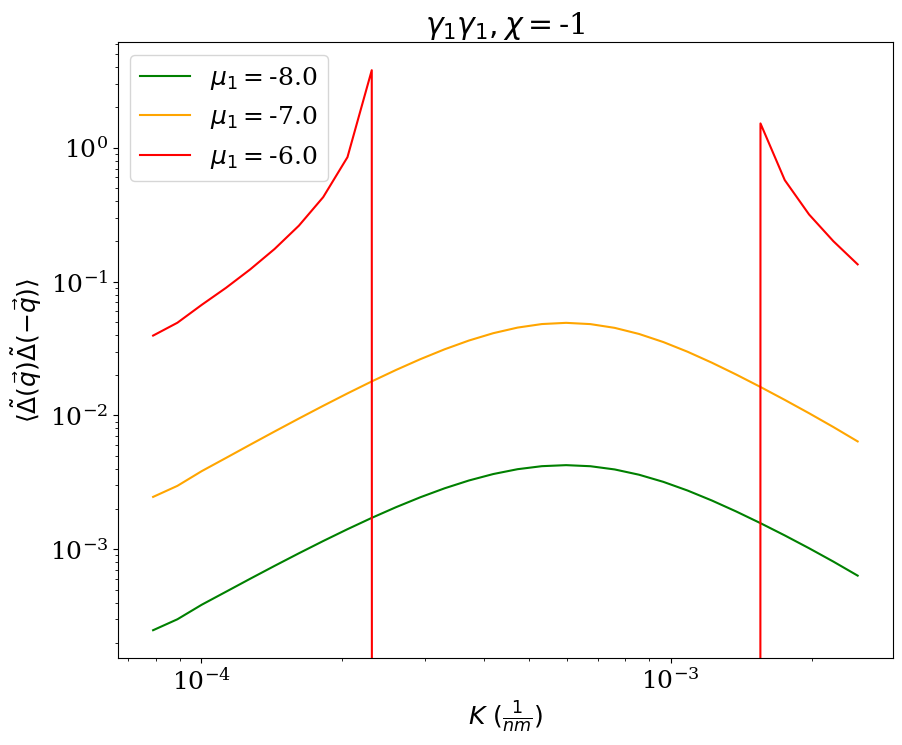

In [79]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$\gamma_1 \gamma_1, \chi = $" + str(chi_A))
plt.xlabel(r'$K \ (\frac{1}{nm})$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g1_corr_arr_chi_A[0], label = "$\mu_1 =$" + str(mu_pnts[0][0]), color = "green")
plt.plot(k_vec, g1g1_corr_arr_chi_A[1], label = "$\mu_1 =$" + str(mu_pnts[1][0]), color = "orange")
plt.plot(k_vec, g1g1_corr_arr_chi_A[2], label = "$\mu_1 =$" + str(mu_pnts[2][0]), color = "red")
plt.legend()
plt.xscale('log')
plt.yscale('log')

#why does it go negative in phase separated system?
# Correlation deiverges as g2 approaches 0. 
# Not physical to think about correlation past divergence, beyond just knowing that it indicates a phase separated system

# mark copoly comparison

In [105]:
from chromo_vertex_nuclear import *

### Full, 2 reader protein analysis (classified/ no binding)

In [94]:
#FULL 2 reader protein anaysis
def calc_sf_mats_copoly(chrom, k_vec = np.logspace(-3, -1, 30)):
    # returns rank 3 tensor of mu1, mu2 , k, each value is S2 matrix                
#     start_time = time.time()
    [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    [marks_1, marks_2] = poly_marks
    len_marks_1 = len(marks_1)
    
    sf_mat = np.zeros(len(k_vec), dtype = "object")

#     s_bnd = np.array([0,1,2,0,1,2])
#     s_bnd = np.array([0,0,.02,0,0,.02])
    s_bnd = np.array([0,1,2])

    cc_red = eval_and_reduce_cc(len_marks_1)

    s_cgam0_red = eval_and_reduce_cgam(s_bnd, poly_marks, 0)

    s_cgam1_red = eval_and_reduce_cgam(s_bnd, poly_marks, 1)

    sisj_AA_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd, 0, 0,)

    sisj_AB_red = eval_and_reduce_sisj_bind_simp( chrom, s_bnd, 0, 1)

    sisj_BA_red = sisj_AB_red

    sisj_BB_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd, 1, 1)

    M2s = [sisj_AA_red,sisj_AB_red,sisj_BA_red,sisj_BB_red, s_cgam0_red, s_cgam1_red, cc_red]


    for ik, k in enumerate(k_vec):
#                 g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo_shlk(chrom, M2s, [k]))
        g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_nuclear(chrom, M2s, [k]))

        ss = 1-phi_c
        S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
                        [0, ss*N**2, 0, 0], \
                        [cg1[0], 0, g1g1[0], g1g2[0]],\
                        [cg2[0], 0, g2g1[0], g2g2[0]]])
        sf_mat[ik] = S2_mat
    return sf_mat

#dens-dens analysis
mu_pnts = np.array([[-7, -6],[-6.5, -5.5], [-6, -5]])
# stab anal

chi_0 = 0

g1g1_corr_arr_chi0_copoly = np.zeros((len(k_vec)))
g1g2_corr_arr_chi0_copoly = np.zeros((len(k_vec)))
g2g2_corr_arr_chi0_copoly = np.zeros((len(k_vec)))

chi_A = 0.5

g1g1_corr_arr_chiA_copoly = np.zeros((len(k_vec)))
g1g2_corr_arr_chiA_copoly = np.zeros((len(k_vec)))
g2g2_corr_arr_chiA_copoly = np.zeros((len(k_vec)))

chi_B = 0.8

g1g1_corr_arr_chiB_copoly = np.zeros((len(k_vec)))
g1g2_corr_arr_chiB_copoly = np.zeros((len(k_vec)))
g2g2_corr_arr_chiB_copoly = np.zeros((len(k_vec)))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

# for i, mu1 in enumerate(mu1_array[:]):
#     for j, mu2 in enumerate(mu2_array[:]):
        
# for ind, mus in enumerate(mu_pnts):
# #         if mu1 == mu2:
# #             continue
#         mu1, mu2 = mus
#         i = np.where(np.round(mu1_array, 1) == mu1)[0][0]
#         j = np.where(np.round(mu2_array, 1) == mu2)[0][0]
s2_mats_copoly = calc_sf_mats_copoly(chrom, k_vec)        

for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

    S2_mat =  s2_mats_copoly[ik]#s2_mats[i][j][ik].copy()
    if ik == 0:
        print(S2_mat)
    S2_mat *= N*vol_nuc
    S2_mat[1][1] /= (N*vol_nuc)
    S2_mat[1][1] *= vol_solv

    if phi_c >= 0.999:
        raise Exception("melt!")

    # FULL SOLUTION 2 reader proteins
    S2_det = np.linalg.det(S2_mat)

#             S2_cond = np.linalg.cond(S2_mat)
#             S2_cond_arr_soln_2[i][j][ik] = S2_cond

    if S2_det != 0:# and S2_cond < 1e10:
        S2_inv = np.linalg.inv(S2_mat)
        G2 = np.array([[S2_inv[0,0] - 2*chi_0 + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
           [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
           [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])

        G2_inv = np.linalg.inv(G2)
        g1g1_corr_arr_chi0_copoly[ik] = G2_inv[1,1] # g1g1
        g1g2_corr_arr_chi0_copoly[ik] = G2_inv[1,2] # g1g2
        g2g2_corr_arr_chi0_copoly[ik] = G2_inv[2,2] # g1g2

        G2 = np.array([[S2_inv[0,0] - 2*chi_A + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
           [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
           [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])

        G2_inv = np.linalg.inv(G2)
        g1g1_corr_arr_chiA_copoly[ik] = G2_inv[1,1] # g1g1
        g1g2_corr_arr_chiA_copoly[ik] = G2_inv[1,2] # g1g2
        g2g2_corr_arr_chiA_copoly[ik] = G2_inv[2,2] # g1g2

        G2 = np.array([[S2_inv[0,0] - 2*chi_B + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
           [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
           [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])

        G2_inv = np.linalg.inv(G2)
        g1g1_corr_arr_chiB_copoly[ik] = G2_inv[1,1] # g1g1
        g1g2_corr_arr_chiB_copoly[ik] = G2_inv[1,2] # g1g2
        g2g2_corr_arr_chiB_copoly[ik] = G2_inv[2,2] # g1g2


### 1 reader protein analysis- HP1 only (classified/ no binding)

In [210]:
# ID = -5.88
disc_mark_chromo = np.loadtxt("H3K9me3_ENCFF651ZTT_Chr_22_trimmed_classified_int.txt")
disc_mark_chromo = disc_mark_chromo.astype(int)

ID = -13.88
looping = "nuc, "
settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

poly_marks = [disc_mark_chromo, np.nan]

chrom = [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b]

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
# s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],DNA,mu_max=%s.npy"\
#                  % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

# density_maps = np.load(r"ID=%s_density_maps.npy" % ID, allow_pickle=True)
# spacing = int(1 / del_mu)

def calc_sf_mats_copoly_HP1(chrom, k_vec = np.logspace(-3, -1, 30)):
    # returns rank 3 tensor of mu1, mu2 , k, each value is S2 matrix                
#     start_time = time.time()
    [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    [marks_1, marks_2] = poly_marks
    len_marks_1 = len(marks_1)
    
    sf_mat = np.zeros(len(k_vec), dtype = "object")


    s_bnd = np.array([0,1,2])
#     s_bnd = np.array([0,0.01,0.02])

    cc_red = eval_and_reduce_cc(len_marks_1)

    s_cgam0_red = eval_and_reduce_cgam(s_bnd, poly_marks, 0)
    
    sisj_AA_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd, 0, 0,)
    
    s_cgam1_red = s_cgam0_red#eval_and_reduce_cgam(s_bnd, poly_marks, 0)
    sisj_AB_red = sisj_AA_red#eval_and_reduce_sisj_bind_simp( chrom, s_bnd, 0, 1)
    sisj_BA_red = sisj_AB_red
    sisj_BB_red = sisj_AA_red#eval_and_reduce_sisj_bind_simp(chrom, s_bnd, 1, 1)

    M2s = [sisj_AA_red,sisj_AB_red,sisj_BA_red,sisj_BB_red, s_cgam0_red, s_cgam1_red, cc_red]


    for ik, k in enumerate(k_vec):
#                 g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_chromo_shlk(chrom, M2s, [k]))
        g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc = phi_c * np.array(calc_sf2_nuclear(chrom, M2s, [k]))

        ss = 1-phi_c
#         S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                         [0, ss*N**2, 0, 0], \
#                         [cg1[0], 0, g1g1[0], g1g2[0]],\
#                         [cg2[0], 0, g2g1[0], g2g2[0]]])

        S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0]],\
                        [0, ss*N**2, 0], \
                        [cg1[0], 0, g1g1[0]] ])
        sf_mat[ik] = S2_mat
    return sf_mat

In [217]:
#dens-dens analysis
# stab anal

chi_0 = 0
g1g1_corr_arr_chi0_copoly = np.zeros((len(k_vec)))

chi_A = -0.5
g1g1_corr_arr_chiA_copoly = np.zeros((len(k_vec)))

chi_B = -1
g1g1_corr_arr_chiB_copoly = np.zeros((len(k_vec)))


A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

s2_mats_copoly_HP1 = calc_sf_mats_copoly_HP1(chrom, k_vec)        

min_eigval_arr = np.zeros(len(k_vec))
for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

    S2_mat =  s2_mats_copoly_HP1[ik]#s2_mats[i][j][ik].copy()
    if ik == 0:
        print(S2_mat)
    S2_mat *= N*vol_nuc
    S2_mat[1][1] /= (N*vol_nuc)
    S2_mat[1][1] *= vol_solv

    if phi_c >= 0.999:
        raise Exception("melt!")
    # 1 reader protein HP1 only
    S2_det = np.linalg.det(S2_mat)

#             S2_cond = np.linalg.cond(S2_mat)
#             S2_cond_arr_soln_2[i][j][ik] = S2_cond

    if S2_det != 0:# and S2_cond < 1e10:
        S2_inv = np.linalg.inv(S2_mat)
        G2 = np.array([[S2_inv[0,0] - 2*chi_0 + S2_inv[1,1], S2_inv[0,2] ],\
           [S2_inv[2,0], S2_inv[2,2] + v_int[0,0] ]] )

        G2_inv = np.linalg.inv(G2)
        g1g1_corr_arr_chi0_copoly[ik] = G2_inv[1,1] # g1g1

        G2 = np.array([[S2_inv[0,0] - 2*chi_A + S2_inv[1,1], S2_inv[0,2] ],\
           [S2_inv[2,0], S2_inv[2,2] + v_int[0,0] ]] )

        G2_inv = np.linalg.inv(G2)
        g1g1_corr_arr_chiA_copoly[ik] = G2_inv[1,1] # g1g1

        G2 = np.array([[S2_inv[0,0] - 2*chi_B + S2_inv[1,1], S2_inv[0,2] ],\
           [S2_inv[2,0], S2_inv[2,2] + v_int[0,0] ]] )

        G2_inv = np.linalg.inv(G2)
        g1g1_corr_arr_chiB_copoly[ik] = G2_inv[1,1] # g1g1
        
        
        val, vec = np.linalg.eigh(G2)
        vec = vec.T
        min_val = np.min(val)            
        min_eigval_arr[ik] = min_val
#         min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

        # all-k analysis
min_vals = min_eigval_arr[np.nonzero(min_eigval_arr)] # min eigvals at mu1,mu2 for each k
print(min_vals)
#         min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
if len(min_vals) != 0:
    minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             min_eigval_arr_allk[i][j] = minval_allk

#             min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects

    k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
    print(k_star)

[[0.39137839 0.         0.52975606]
 [0.         0.6        0.        ]
 [0.52975606 0.         0.71989684]]
[-3.99637445 -3.99700576 -3.9976644  -3.99813287 -3.99850757 -3.99880252
 -3.99903465 -3.9992172  -3.99936057 -3.99947288 -3.99956052 -3.99962851
 -3.99968064 -3.99971986 -3.99974835 -3.99976761 -3.99977862 -3.9997818
 -3.99977708 -3.9997639  -3.99974114 -3.99970716 -3.99965965 -3.99959555
 -3.9995108  -3.99940005 -3.99925603 -3.99906842 -3.99882183 -3.99849254]
[0.00059876]


In [216]:
1/k_star

array([1670.12757462])

In [131]:
g1g1_corr_arr_chi0_copoly

array([ 0.0311112 ,  0.03866163,  0.051789  ,  0.06829991,  0.09170011,
        0.12559073,  0.17713373,  0.26159797,  0.41827855,  0.78819056,
        2.54404117, -3.49316267, -1.2387469 , -0.83380103, -0.67383541,
       -0.59643815, -0.55971273, -0.5499285 , -0.56456508, -0.60995433,
       -0.7081984 , -0.93249332, -1.67344544, 23.2079888 ,  1.12369529,
        0.50092096,  0.29113539,  0.18838448,  0.12870578,  0.09045751])

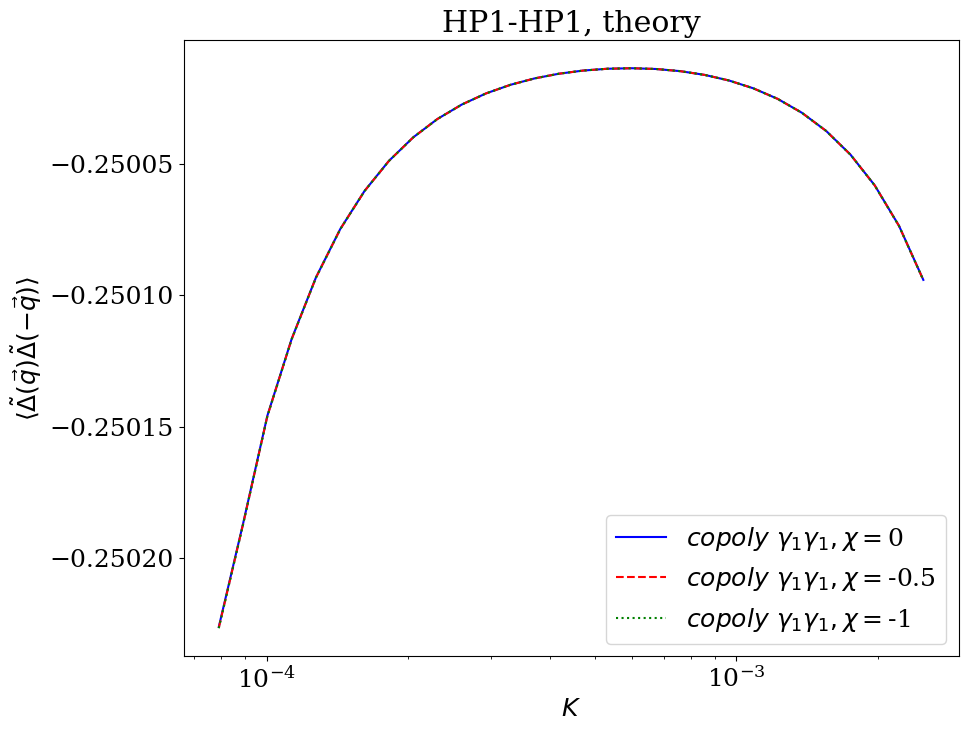

In [213]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("HP1-HP1, theory")
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')


plt.plot(k_vec, g1g1_corr_arr_chi0_copoly, label = "$copoly \ \gamma_1 \gamma_1, \chi = $" + str(chi_0), color = "blue")

plt.plot(k_vec, g1g1_corr_arr_chiA_copoly, label = "$copoly \ \gamma_1 \gamma_1, \chi = $" + str(chi_A), linestyle = "--", color = "red")

plt.plot(k_vec, g1g1_corr_arr_chiB_copoly, label = "$copoly \ \gamma_1 \gamma_1, \chi = $" + str(chi_B), linestyle="dotted", color = "green")


plt.legend()
plt.xscale('log')
# plt.yscale('log')

#why does it go negative in phase separated system?
# Correlation deiverges as g2 approaches 0. 
# Not physical to think about correlation past divergence, beyond just knowing that it indicates a phase separated system

# Simulation

In [3]:
# import sys
# sys.path.insert(1, './wlcstat/')
import numpy as np
# import scipy.special as sp
# import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

import itertools 
import pandas as pd

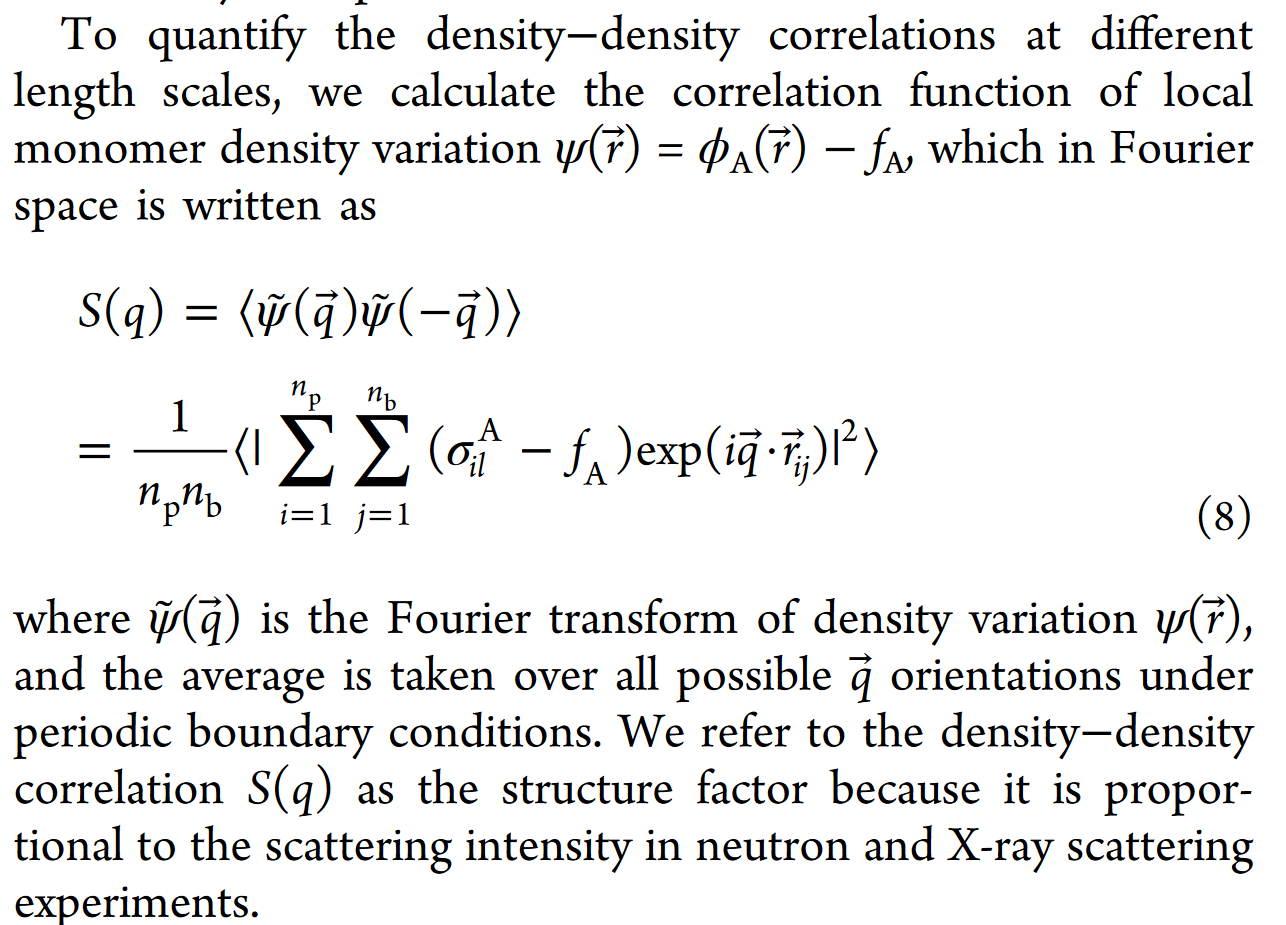

In [5]:
# for chromo
def gen_triples_vector(rnge):
    #to make sute itertools.combinations creates all permutations
    lst = []
    for i in range(rnge):
        lst += ([i]*3)
    return lst

def get_mag_vec_map(rnge, l_box = 20):
    comb_dict = {}
    #gen apropraiate vector
    trips = gen_triples_vector(rnge)
    for comb in itertools.combinations(trips, 3):
        comb = np.array(comb)
#         comb_mag = np.linalg.norm(comb* (2*np.pi/l_box))
        comb_mag = np.linalg.norm(comb* (1/l_box))
        # if comb_mag not in dictionary
        if comb_mag not in comb_dict:
            comb = comb * (2*np.pi/l_box)
            permutes = list(itertools.permutations(comb))
            for i in range(len(permutes)):
                #permutes[i] = list(permutes[i])
                permutes[i] = np.array(list(permutes[i]))
            permutes = np.unique(np.array(permutes), axis=0)
            comb_dict[comb_mag] = permutes
    return comb_dict

def get_sigma_array(df, bead_type):
    sigma = np.array([])
    
    if bead_type == "A":
        sigma = df.Type
        
    elif bead_type == "B": #reverse the sigma 
        sigma = df.Type.replace([0, 1], [1, 0])
        
    return sigma
# (df, q_vectors, n_p, n_b, f_hp1, phi_poly, bead_type = bd_type)
def structure_factor_from_chromo(df, q_vectors, n_p, n_b, f_A, phi_poly, bead_type = "A"):
    '''
    structure factor. Calculates the value of the structure factor for a single magnitude of q (set of q vectors 
    with the same magnitude)  
    q_vectors is a list of vectors with same magnitude
    '''
#     sigma = get_sigma_array(df, bead_type)
    sigma = df[bead_type].astype(int)          
    sum_avg = 0
    for q_vect in q_vectors:
        summ = 0
        A = sigma - f_A*phi_poly #replaced df.Type with sigma
        B = 1j*np.dot(df.iloc[:,:3].astype(float), q_vect)
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
    return sum_avg * (1/(n_p*n_b))

In [9]:
# def get_mag_vec_map_verbose(rnge, l_box = 20):
#     comb_dict = {}
#     #gen apropraiate vector
#     trips = gen_triples_vector(rnge)
#     print("trips:",trips)
#     for comb in itertools.combinations(trips, 3):
#         comb = np.array(comb)
#         print("comb:", comb)
#         comb_mag = np.linalg.norm(comb* (2*np.pi/l_box))
#         # if comb_mag not in dictionary
#         if comb_mag not in comb_dict:
#             print("mag:", comb_mag)
#             comb = comb * (2*np.pi/l_box)
#             permutes = list(itertools.permutations(comb))
#             for i in range(len(permutes)):
#                 #permutes[i] = list(permutes[i])
#                 permutes[i] = np.array(list(permutes[i]))
#             permutes = np.unique(np.array(permutes), axis=0)
#             comb_dict[comb_mag] = permutes
#     return comb_dict
# get_mag_vec_map_verbose(2, l_box = 10000)

In [11]:
# df = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\Chr-1-7.csv")

# pos_id = df[['r', 'r.1', 'r.2', "states", "states.1"]].copy()
# pos_id.columns = pos_id.iloc[0]
# pos_id = pos_id.drop(0)
# #calculate 

In [51]:
import os

# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\mu1_-4"
# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\mu1_-3"
# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\mu1_-2"

# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\no_binding"
# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\diblock_FA0.5_no_binding"

# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\joe_paper_reproduce\sim_15_-1_-4"
# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\joe_paper_reproduce\sim_13_-1_-1"
directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\joe_paper_reproduce\sim_14_-1_1"

directory = os.fsencode(directory_in_str)

df_list = []
filename_list = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    full_path = os.fsdecode(os.path.join(directory, file))
    if filename.endswith(".csv"):
        df = pd.read_csv(full_path)
        # print(df.head())
        pos_id = df[['r', 'r.1', 'r.2', "states", "states.1"]].copy()
        pos_id.columns = pos_id.iloc[0]
        pos_id = pos_id.drop(0)
        
        df_list.append(pos_id)
        filename_list.append(filename)

C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1182622520.py:22: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1182622520.py:22: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1182622520.py:22: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)


In [53]:
filename_list

['Chr_refineSpherical-11-17.csv',
 'Chr_refineSpherical-11-18.csv',
 'Chr_refineSpherical-11-19.csv']

In [55]:
f_HP1_list = []
# f_PRC1_list = []
for df in df_list: #avging over ensembles
    n_p = 1
    n_b = len(df)#253902
    f_hp1 = df["HP1"].astype(int).sum()/(n_b*2)
    f_HP1_list.append(f_hp1)
    print(f_hp1)
#     f_prc1 = df["PRC1"].astype(int).sum()/(n_b*2)
#     f_PRC1_list.append(f_prc1)


0.22120825695385352
0.22210156478308227
0.22283989975470012


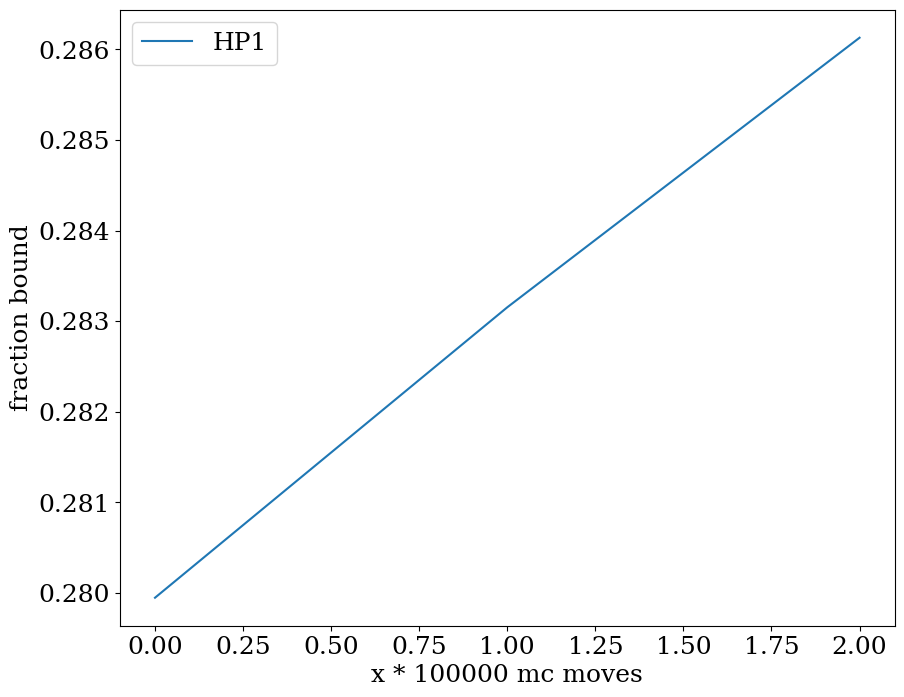

In [45]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(range(len(df_list)), f_HP1_list, label = "HP1")
# plt.plot(range(len(df_list)), f_PRC1_list, label = "PRC1")
# plt.xscale("log")
# plt.yscale("log")

# plt.ylim(10**-2, 10**2)
plt.title("")
plt.xlabel(r'x * 100000 mc moves')
plt.ylabel(r'fraction bound')
plt.legend()

In [70]:
len(sorted_magnitudes)

834

In [72]:
%%time
# df_list = [pos_id]

mag_vects_map = get_mag_vec_map(20, l_box = 10000)
# mag_vects_map = get_mag_vec_map(40, l_box = 100000)
sorted_magnitudes = sorted(mag_vects_map.keys())
sort_mags = np.array(sorted_magnitudes)   

structure_fact_array = np.array([])

bd_type = "HP1"

for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
    sf_average = 0
    from_bins = None
    for df in df_list: #avging over ensembles
        n_p = 1
        n_b = len(df)#253902
        f_hp1 = df["HP1"].astype(int).sum()/(n_b*2)
#         print(f_hp1)
#         f_prc1 = df["PRC1"].astype(int).sum()/(n_b*2)
        phi_poly = 0.4 # NOT RIGHT! TODO: actually calculate
        
        sf = structure_factor_from_chromo(df, q_vectors, n_p, n_b, f_hp1, phi_poly, bead_type = bd_type)

#         if df.columns[0] == "X": # position data
#             from_bins = False
#             sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly, l_box=20, bead_type = bd_type)
#         elif df.columns[0] == "Phi_A": # bin data
#             from_bins = True
#             sf = structure_factor_from_sim_bins(df, q_vectors, bin_pos_array, tot_num_bins, bead_type = bd_type)

        sf_average += sf/(len(df_list)) 
    structure_fact_array = np.append(structure_fact_array, sf_average)

CPU times: total: 7min 7s
Wall time: 19min 26s


In [16]:
# R_M = 2*l_pers*(N_M - 0.5*(1-np.exp(-2*N_M)))**0.5 #unperturbed average end-to-end separation of a monomer- length of monomer
# sort_mags*R_M

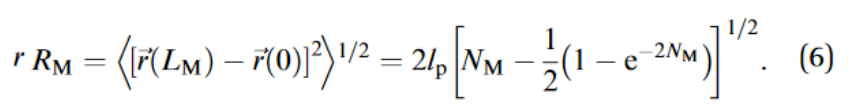

Text(0, 0.5, 'Structure Factor $S_{2}(K)$')

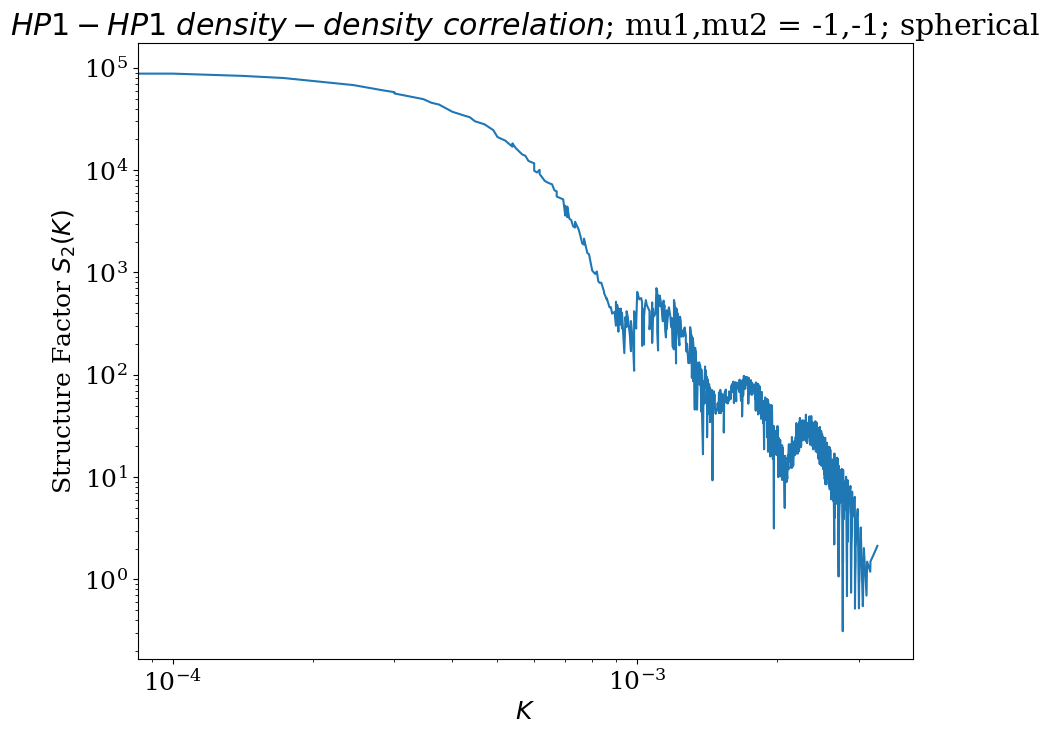

In [73]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(sort_mags, structure_fact_array)
plt.xscale("log")
plt.yscale("log")

# plt.ylim(10**-2, 10**2)
plt.title("$HP1 - HP1 \  density-density \  correlation$; mu1,mu2 = -1,-1; spherical")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K)$')

Text(0, 0.5, 'Structure Factor $S_{2}(K)$')

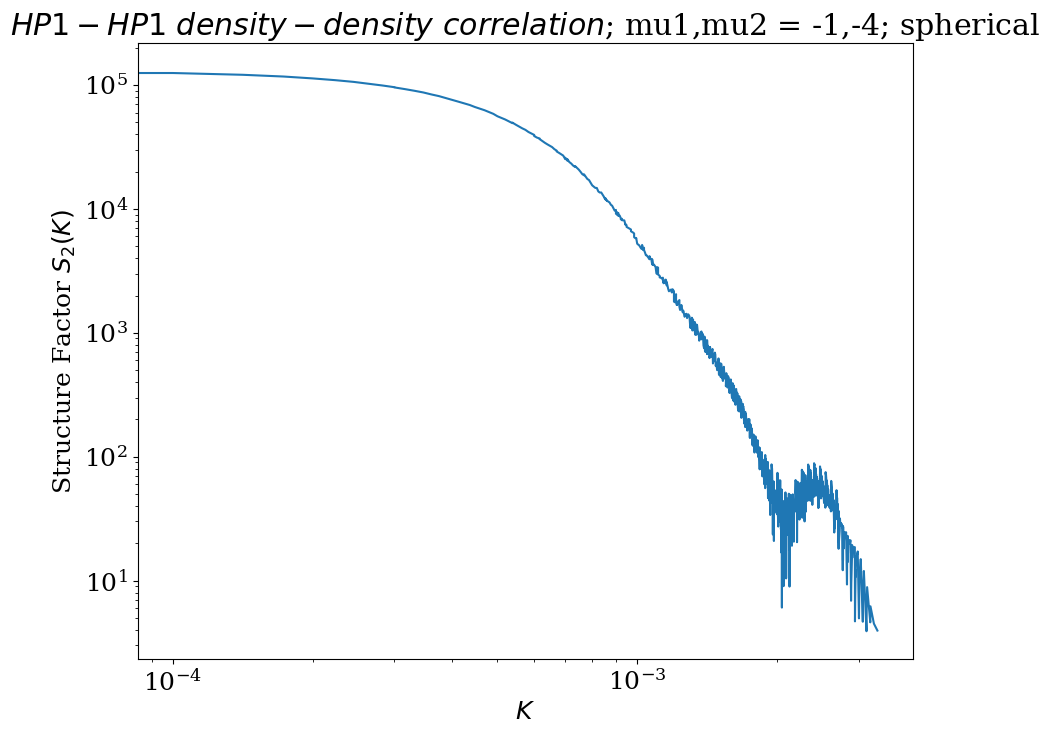

In [28]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(sort_mags, structure_fact_array)
plt.xscale("log")
plt.yscale("log")

# plt.ylim(10**-2, 10**2)
plt.title("$HP1 - HP1 \  density-density \  correlation$; mu1,mu2 = -1,-4; spherical")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K)$')

In [58]:
structure_fact_array_mu4 = structure_fact_array

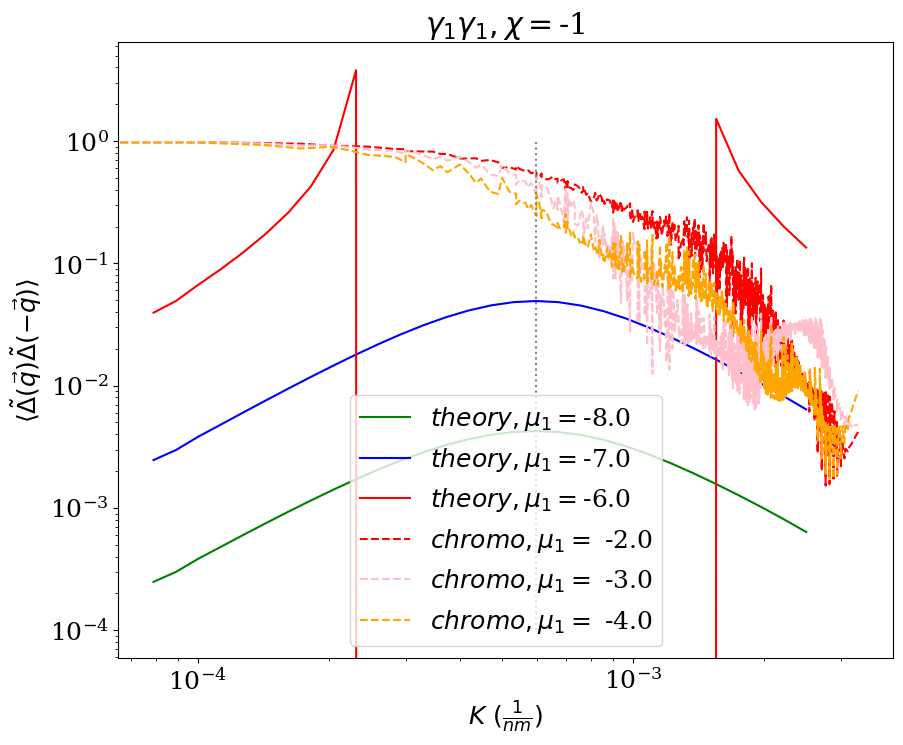

In [80]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$\gamma_1 \gamma_1, \chi = $" + str(chi_A))
plt.xlabel(r'$K \ (\frac{1}{nm})$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g1_corr_arr_chi_A[0], label = "$theory,\mu_1 =$" + str(mu_pnts[0][0]), color = "green")
plt.plot(k_vec, g1g1_corr_arr_chi_A[1], label = "$theory, \mu_1 =$" + str(mu_pnts[1][0]), color = "blue")
plt.plot(k_vec, g1g1_corr_arr_chi_A[2], label = "$theory,\mu_1 =$" + str(mu_pnts[2][0]), color = "red")

plt.plot(sort_mags, structure_fact_array_mu2/(structure_fact_array_mu2[0]), linestyle= "--",label = "$chromo, \mu_1 =$ -2.0", color = "red")
plt.plot(sort_mags, structure_fact_array_mu3/(structure_fact_array_mu3[0]), linestyle= "--", label = "$chromo, \mu_1 =$ -3.0", color = "pink")
plt.plot(sort_mags, structure_fact_array_mu4/(structure_fact_array_mu4[0]), linestyle= "--",label = "$chromo, \mu_1 =$ -4.0", color = "orange")

k_star = 1/1670.127574

plt.vlines(k_star, 0.0001, 1, linestyle = "dotted", color = "gray")
plt.legend()
plt.xscale('log')
plt.yscale('log')

#why does it go negative in phase separated system?
# Correlation deiverges as g2 approaches 0. 
# Not physical to think about correlation past divergence, beyond just knowing that it indicates a phase separated system

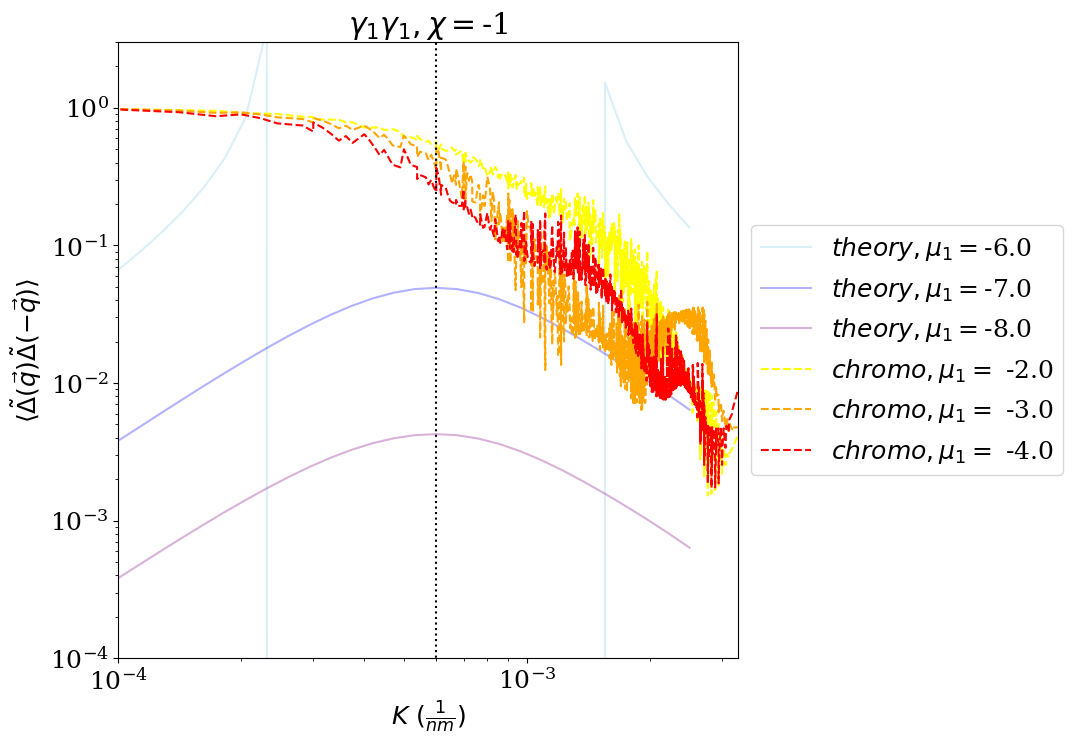

In [101]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = plt.subplot(111)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.title("$\gamma_1 \gamma_1, \chi = $" + str(chi_A))
plt.xlabel(r'$K \ (\frac{1}{nm})$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g1_corr_arr_chi_A[2], label = "$theory,\mu_1 =$" + str(mu_pnts[2][0]), color = "skyblue", alpha = 0.3)
plt.plot(k_vec, g1g1_corr_arr_chi_A[1], label = "$theory, \mu_1 =$" + str(mu_pnts[1][0]), color = "blue", alpha = 0.3)

plt.plot(k_vec, g1g1_corr_arr_chi_A[0], label = "$theory,\mu_1 =$" + str(mu_pnts[0][0]), color = "purple", alpha = 0.3)


plt.plot(sort_mags, structure_fact_array_mu2/(structure_fact_array_mu2[0]), linestyle= "--",label = "$chromo, \mu_1 =$ -2.0",alpha = 1, color = "yellow")
plt.plot(sort_mags, structure_fact_array_mu3/(structure_fact_array_mu3[0]), linestyle= "--", label = "$chromo, \mu_1 =$ -3.0",alpha = 1, color = "orange")
plt.plot(sort_mags, structure_fact_array_mu4/(structure_fact_array_mu4[0]), linestyle= "--",label = "$chromo, \mu_1 =$ -4.0", color = "red")

k_star = 1/1670.127574

plt.vlines(k_star, 0.00001, 10, linestyle = "dotted", color = "black")
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xlim(1e-4, sort_mags[-1])
plt.ylim(1e-4, 3)


leg=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#why does it go negative in phase separated system?
# Correlation deiverges as g2 approaches 0. 
# Not physical to think about correlation past divergence, beyond just knowing that it indicates a phase separated system

In [ ]:
k_star = 1/1670.127574

In [248]:

# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,8))
# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# plt.plot(sort_mags, structure_fact_array)
# plt.xscale("log")
# plt.yscale("log")

# # plt.ylim(10**-2, 10**2)
# plt.title("$HP1 - HP1 \  density-density \  correlation$ no binding")
# plt.xlabel(r'$K$')
# plt.ylabel(r'Structure Factor $S_{2}(K)$')

In [76]:

# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,8))
# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# plt.plot(sort_mags, structure_fact_array)
# plt.xscale("log")
# plt.yscale("log")

# # plt.ylim(10**-2, 10**2)
# plt.title("$HP1 - HP1 \  density-density \  correlation$ one sim")
# plt.xlabel(r'$K$')
# plt.ylabel(r'Structure Factor $S_{2}(K)$')

In [158]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10, 8))
# ax1 = fig.add_subplot(111,projection='3d')

# test = df_list[0]

# colors = ['blue', 'green', 'red']
# # for i in range(len(test)):
# #     x, y, z = test.iloc[i]['x'], test.iloc[i]['y'], test.iloc[i]['z']
# #     ax1.scatter(x, y, z, c=colors[int(test.iloc[i]['HP1'])])

# ax1.scatter(test.x, test.y, test.z)#, c=colors[int(test.iloc[i]['HP1'])])

0
1
2
79218


C:\Users\tmhab\AppData\Local\Temp\ipykernel_21680\899716016.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


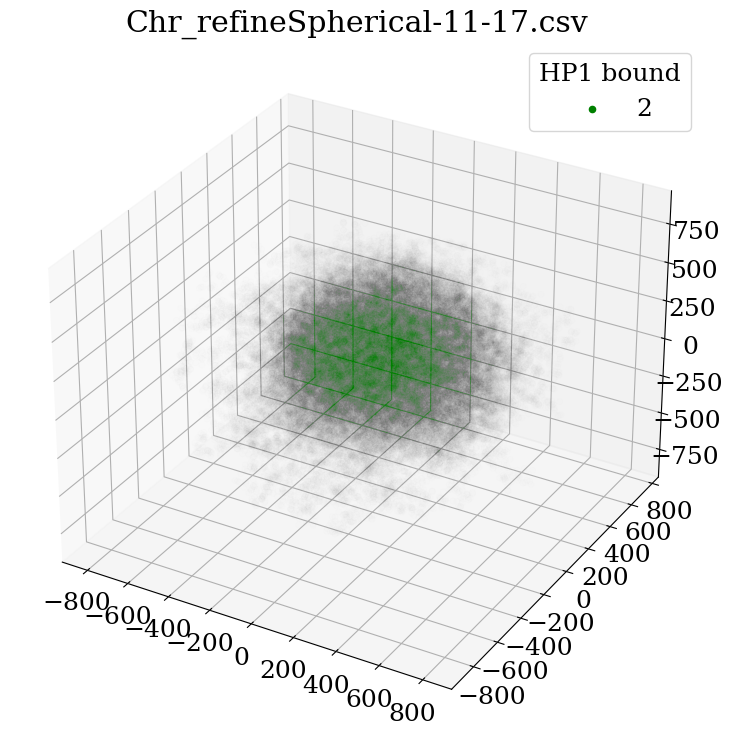

0
1
2
79598


C:\Users\tmhab\AppData\Local\Temp\ipykernel_21680\899716016.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


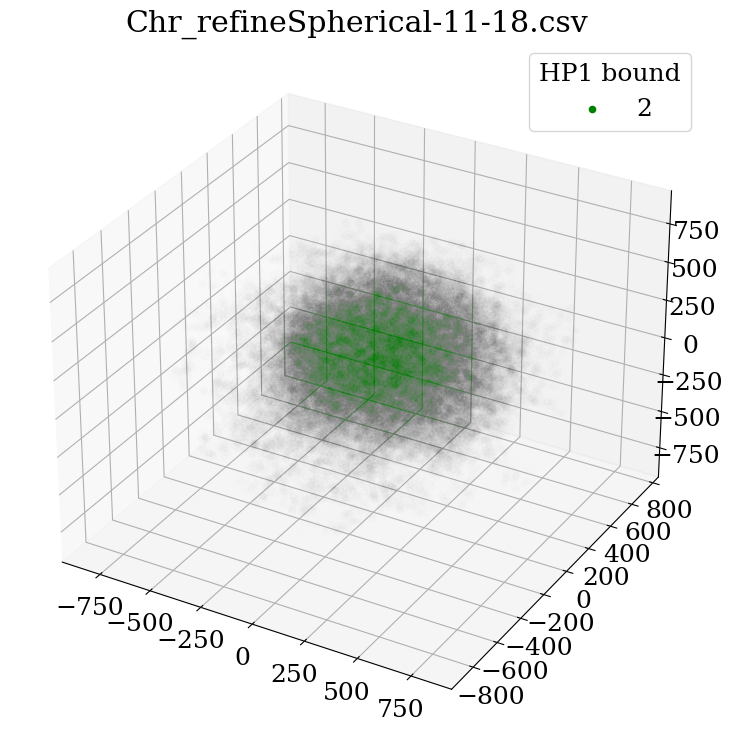

0
1
2
79854


C:\Users\tmhab\AppData\Local\Temp\ipykernel_21680\899716016.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


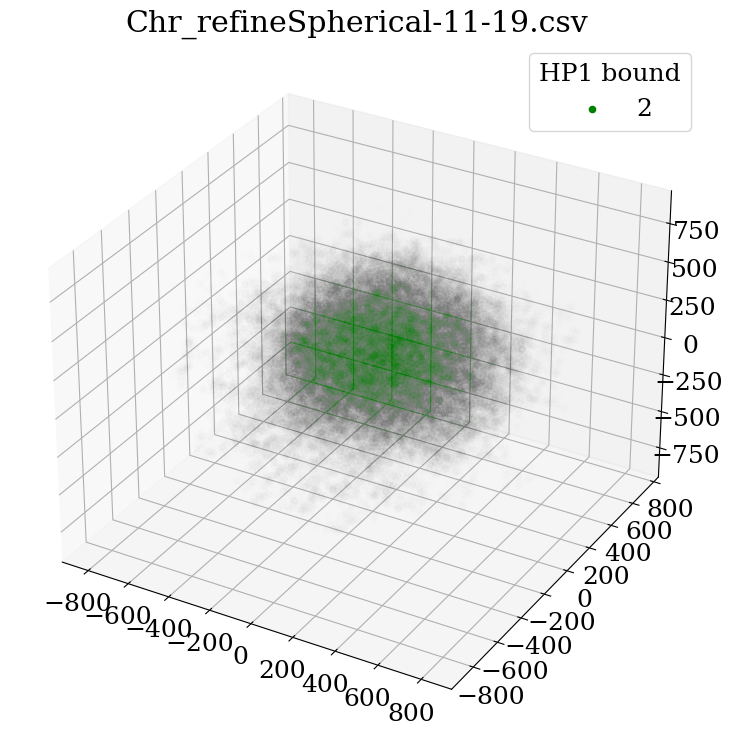

In [60]:
for i, df in enumerate(df_list):
    filename = filename_list[i]
    df['HP1'] = df['HP1'].astype(int)
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df['z'] = df['z'].astype(float)
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(projection='3d')
    # colors = ['blue', 'green', 'red']
    colors = ['green', 'red']
    # colors = {}
    i=0
    for grp_name, grp_idx in df.groupby('HP1').groups.items():
    #     print(grp_idx)
        print(grp_name)
        if grp_name == 0 or grp_name == 1:
            continue
        # if grp_name == 0:
            # continue
        x = df.x.iloc[grp_idx-1]
        y = df.y.iloc[grp_idx-1]
        z = df.z.iloc[grp_idx-1]
        print(len(x))
    #     y = df.iloc[grp_idx-1,1]
    #     x = df.iloc[grp_idx-1,0]
    #     z = df.iloc[grp_idx-1,2]
#         ax.scatter(x, y, z, label=grp_name, color=colors[i], alpha = 0.025 )  # this way you can control color/marker/size of each group freely
        ax.scatter(x, y, z, label=grp_name, color=colors[i], alpha = 0.002 )  # this way you can control color/marker/size of each group freely
    #     ax.scatter(*df.iloc[grp_idx, [0, 1, 2]].T.values, label=grp_name )  # if you want to do everything in one line, lol
        i+=1
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
    leg = plt.legend(title="HP1 bound")
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.title(filename)
#     ax.view_init(30, 30, 30)
    plt.show()

0
1
2
172220


C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1827610135.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


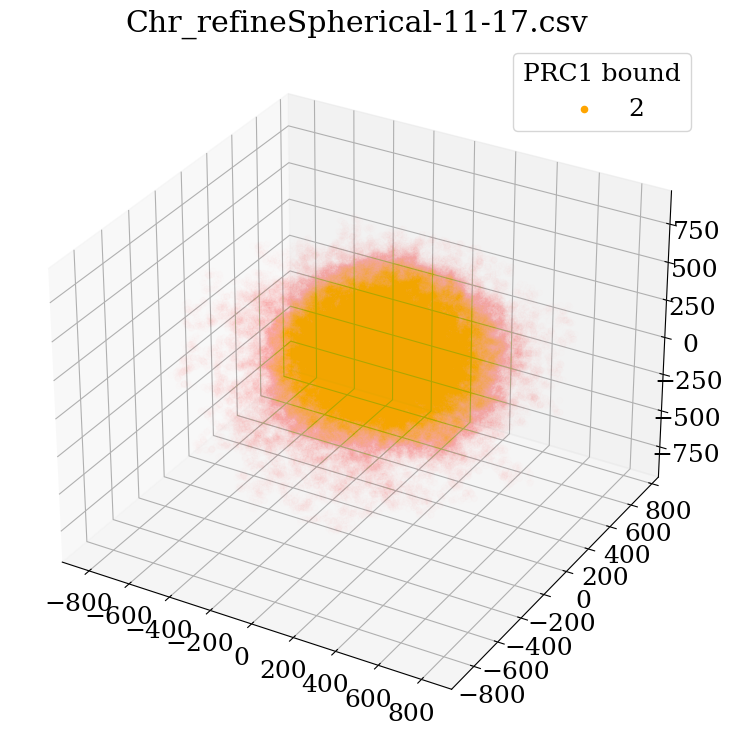

0
1
2
174750


C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1827610135.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


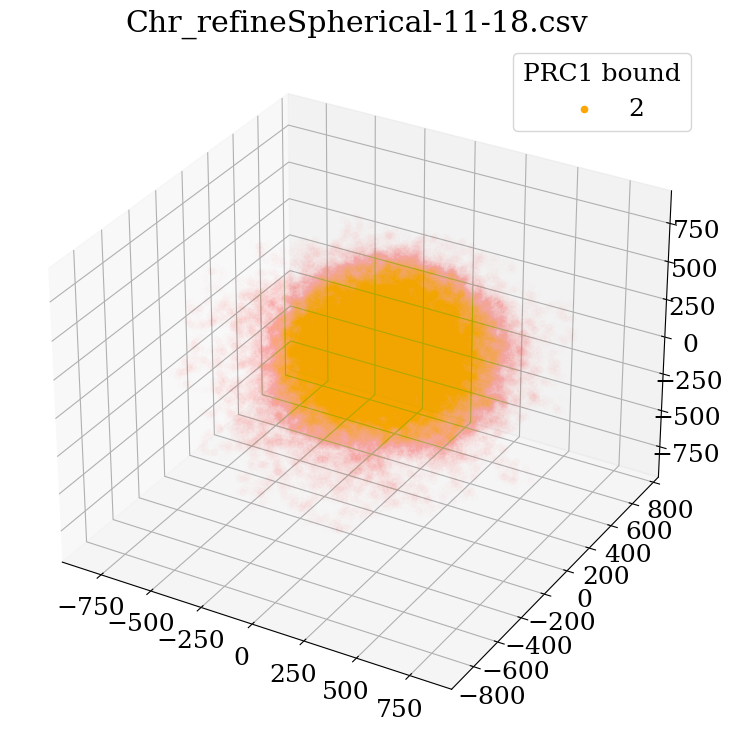

0
1
2
177127


C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1827610135.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


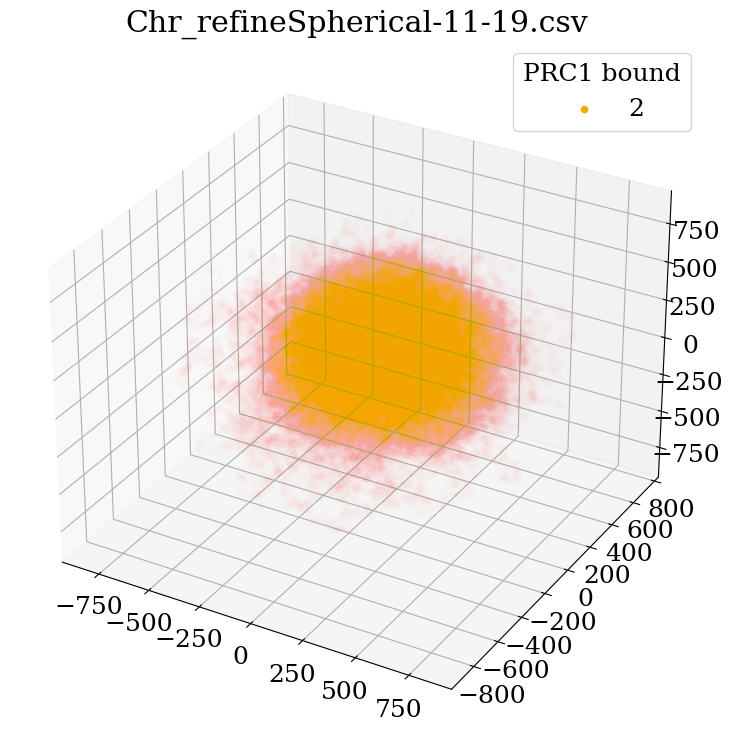

In [57]:
for i, df in enumerate(df_list):
    filename = filename_list[i]
    # print(df.head())
    df['PRC1'] = df['PRC1'].astype(int)
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df['z'] = df['z'].astype(float)
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(projection='3d')
    # colors = ['orange', 'purple', 'pink']
    colors = ['orange', 'purple']
    # colors = {}
    i=0
    for grp_name, grp_idx in df.groupby('PRC1').groups.items():
    #     print(grp_idx)
        print(grp_name)
        if grp_name == 0 or grp_name == 1:
            continue
        # if grp_name == 0:
            # continue
        x = df.x.iloc[grp_idx-1]
        y = df.y.iloc[grp_idx-1]
        z = df.z.iloc[grp_idx-1]
        print(len(x))
    #     y = df.iloc[grp_idx-1,1]
    #     x = df.iloc[grp_idx-1,0]
    #     z = df.iloc[grp_idx-1,2]
#         ax.scatter(x, y, z, label=grp_name, color=colors[i], alpha = 0.025 )  # this way you can control color/marker/size of each group freely
        ax.scatter(x, y, z, label=grp_name, color=colors[i], alpha = 0.002 )  # this way you can control color/marker/size of each group freely
    #     ax.scatter(*df.iloc[grp_idx, [0, 1, 2]].T.values, label=grp_name )  # if you want to do everything in one line, lol
        i+=1
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
    leg = plt.legend(title="PRC1 bound")
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.title(filename)
#     ax.view_init(30, 30, 30)
    plt.show()

# Multiple sim sf comparison 

In [83]:
label_list

['C:\\Users\\tmhab\\wlcsim_membrane\\chrom_stab\\chromo_output\\joe_paper_reproduce\\sim_15_-1_',
 'C:\\Users\\tmhab\\wlcsim_membrane\\chrom_stab\\chromo_output\\joe_paper_reproduce\\sim_13_-1_',
 'C:\\Users\\tmhab\\wlcsim_membrane\\chrom_stab\\chromo_output\\joe_paper_reproduce\\sim_14_-1']

In [65]:
import os

# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\mu1_-4"
# directory_in_str1 = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\mu1_-4"
# directory_in_str2 = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\mu1_-3"
# directory_in_str3 = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\mu1_-2"

directory_in_str1 = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\joe_paper_reproduce\sim_15_-1_-4"
directory_in_str2 = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\joe_paper_reproduce\sim_13_-1_-1"
directory_in_str3 = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\joe_paper_reproduce\sim_14_-1_1"

str_list = [directory_in_str1, directory_in_str2, directory_in_str3]
# directory_in_str = r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\chromo_output\no_binding"
# label_list = [directory_in_str1[:-2], directory_in_str2[:-2], directory_in_str3[:-2]]
df_list_list = np.zeros(len(str_list), dtype = "object") # for each mu value, corresponds to a list of df sim output
for i, directory_in_str in enumerate(str_list):
    directory = os.fsencode(directory_in_str)

    df_list = []
    filename_list = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        full_path = os.fsdecode(os.path.join(directory, file))
        if filename.endswith(".csv"):
            df = pd.read_csv(full_path)

            pos_id = df[['r', 'r.1', 'r.2', "states", "states.1"]].copy()
            pos_id.columns = pos_id.iloc[0]
            pos_id = pos_id.drop(0)

            df_list.append(pos_id)
            filename_list.append(filename)

    df_list_list[i] = df_list

C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1211656684.py:25: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1211656684.py:25: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1211656684.py:25: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1211656684.py:25: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_40644\1211656684.py:25: DtypeWarning: Co

In [67]:
len(df_list_list)

3

In [78]:
%%time
# df_list = [pos_id]
sf_list = np.zeros(len(df_list_list), dtype=object)
for i, df_list in enumerate(df_list_list):
    mag_vects_map = get_mag_vec_map(20, l_box = 1800) 
    # mag_vects_map = get_mag_vec_map(40, l_box = 100000)
    sorted_magnitudes = sorted(mag_vects_map.keys())
    sort_mags = np.array(sorted_magnitudes)   

    structure_fact_array = np.array([])

    bd_type = "HP1"

    for mag in sorted_magnitudes:
        q_vectors = mag_vects_map[mag]
        sf_average = 0
        from_bins = None
        for df in df_list: #avging over ensembles
            n_p = 1
            n_b = len(df)#253902
            f_hp1 = df["HP1"].astype(int).sum()/(n_b*2)
    #         print(f_hp1)
    #         f_prc1 = df["PRC1"].astype(int).sum()/(n_b*2)
            phi_poly = 0.4 # NOT RIGHT! TODO: actually calculate

            sf = structure_factor_from_chromo(df, q_vectors, n_p, n_b, f_hp1, phi_poly, bead_type = bd_type)

    #         if df.columns[0] == "X": # position data
    #             from_bins = False
    #             sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly, l_box=20, bead_type = bd_type)
    #         elif df.columns[0] == "Phi_A": # bin data
    #             from_bins = True
    #             sf = structure_factor_from_sim_bins(df, q_vectors, bin_pos_array, tot_num_bins, bead_type = bd_type)

            sf_average += sf/(len(df_list)) 
        structure_fact_array = np.append(structure_fact_array, sf_average)
    sf_list[i] = structure_fact_array 
    print("ONE SF SAVED")

ONE SF SAVED
ONE SF SAVED
ONE SF SAVED
CPU times: total: 16min 34s
Wall time: 47min 23s


In [72]:
%%time
# df_list = [pos_id]
sf_list_PRC1 = np.zeros(len(df_list_list), dtype=object)
for i, df_list in enumerate(df_list_list):
    mag_vects_map = get_mag_vec_map(20, l_box = 1800) #l_box should be 1800 
    # mag_vects_map = get_mag_vec_map(40, l_box = 100000)
    sorted_magnitudes = sorted(mag_vects_map.keys())
    sort_mags = np.array(sorted_magnitudes)   

    structure_fact_array = np.array([])

    bd_type = "PRC1"

    for mag in sorted_magnitudes:
        q_vectors = mag_vects_map[mag]
        sf_average = 0
        from_bins = None
        for df in df_list: #avging over ensembles
            n_p = 1
            n_b = len(df)#253902
            f_hp1 = df["PRC1"].astype(int).sum()/(n_b*2)
    #         print(f_hp1)
    #         f_prc1 = df["PRC1"].astype(int).sum()/(n_b*2)
            phi_poly = 0.4 # NOT RIGHT! TODO: actually calculate

            sf = structure_factor_from_chromo(df, q_vectors, n_p, n_b, f_hp1, phi_poly, bead_type = bd_type)

    #         if df.columns[0] == "X": # position data
    #             from_bins = False
    #             sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly, l_box=20, bead_type = bd_type)
    #         elif df.columns[0] == "Phi_A": # bin data
    #             from_bins = True
    #             sf = structure_factor_from_sim_bins(df, q_vectors, bin_pos_array, tot_num_bins, bead_type = bd_type)

            sf_average += sf/(len(df_list)) 
        structure_fact_array = np.append(structure_fact_array, sf_average)
    sf_list_PRC1[i] = structure_fact_array 
    print("ONE SF SAVED")

ONE SF SAVED
ONE SF SAVED
ONE SF SAVED
CPU times: total: 16min 48s
Wall time: 47min 32s


In [93]:
np.shape(sf_list)

(3,)

Text(0, 0.5, 'Structure Factor $S_{2}(K)$')

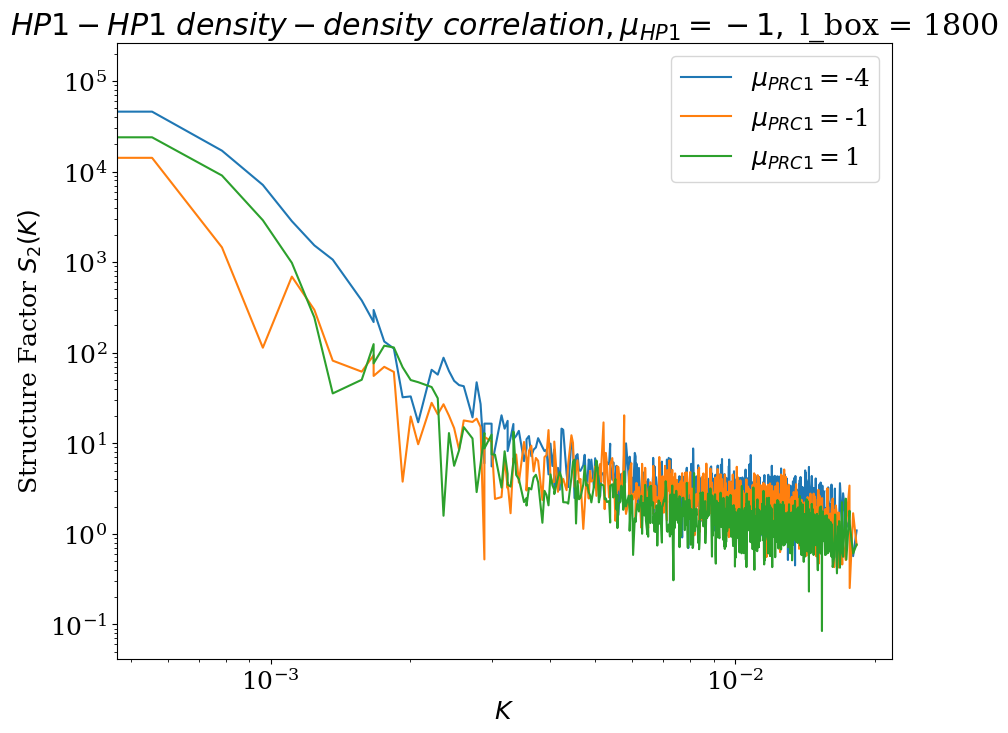

In [82]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
lbls = ["-4", "-1", "1"]
for i, sf in enumerate(sf_list):
    plt.plot(sort_mags, sf, label = "$ \mu_{PRC1} = $" + lbls[i])
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.ylim(10**-2, 10**2)
plt.title("$HP1 - HP1 \  density-density \  correlation, \mu_{HP1} = -1,$ l_box = 1800")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K)$')

In [61]:
1/1800

0.0005555555555555556

Text(0, 0.5, 'Structure Factor $S_{2}(K)$')

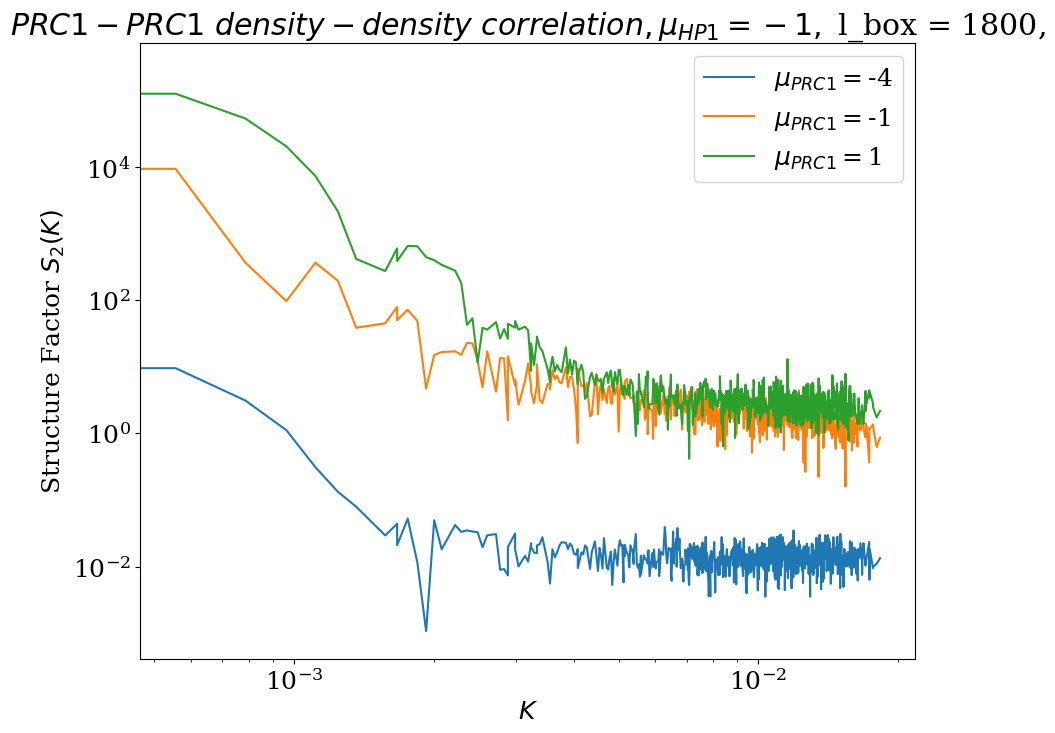

In [76]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
lbls = ["-4", "-1", "1"]
for i, sf in enumerate(sf_list_PRC1):
    plt.plot(sort_mags, sf, label = "$ \mu_{PRC1} = $" + lbls[i])
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.ylim(10**-2, 10**2)
plt.title("$PRC1 - PRC1 \  density-density \  correlation, \mu_{HP1} = -1,$ l_box = 1800,")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K)$')

In [ ]:
# %%time

# df_chi_list = []
# chi_list = []
# lam_list = []
# EPS_list = []
# L0_list = []
# n_p_list = []

# for pth in path_list:
    
#     data_path = pth[0]
#     consts_path = pth[1]
#     os.chdir(data_path)
    
#     if data_path[-3] == "r": # means a folder of position files:
#         name_list = ["X", "Y", "Z", "Type"]
#     elif data_path[-5] == "p": # folder of vol frac files
#         name_list = ["Phi_A", "Phi_B"]
     
#     df_list = []
#     for file in os.listdir():
#         file_path = f"{data_path}\{file}"
#         file_df = pd.read_csv(file_path, names = name_list, delim_whitespace=True)
#         df_list.append(file_df)
#     consts =  pd.read_csv(consts_path, header=None, names = ["const", "value"])#, names = name_list, delim_whitespace=True)
#     chi_list.append(consts.iloc[0, 1])
#     lam_list.append(consts.iloc[1, 1])
#     EPS_list.append(consts.iloc[2, 1])
#     L0_list.append(consts.iloc[3, 1])
#     n_p_list.append(consts.iloc[4, 1])
#     df_chi_list.append([df_list, consts.iloc[0, 1], consts.iloc[4, 1]]) #list of data frames and their chi value and num polymers
    
    
# #MOST ROBUST SOLUTION
# mag_vects_map = get_mag_vec_map(20, l_box = 20)
# sorted_magnitudes = sorted(mag_vects_map.keys())
# sort_mags = np.array(sorted_magnitudes)           

# # for phi sf calculations
# tot_num_bins = num_bins_per_side**2
# bin_ind_dict = get_bin_ind_dict(num_bins_per_side)
# bin_pos_array = np.array(list(bin_ind_dict.values())) # array of bin positions that correspond to 1D bin index

# structure_fact_array_list = []
# for df_pair in df_chi_list:
#     df_list = df_pair[0]
#     chi_value = df_pair[1]
#     n_p = df_pair[2]
#     phi_poly = n_p/2000
#     print(n_p)

#     structure_fact_array = np.array([])
#     for mag in sorted_magnitudes:
#         q_vectors = mag_vects_map[mag]
#         sf_average = 0
#         from_bins = None
#         for df in df_list: #avging over ensembles
#             if df.columns[0] == "X": # position data
#                 from_bins = False
#                 sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly, l_box=20, bead_type = bd_type)
#             elif df.columns[0] == "Phi_A": # bin data
#                 from_bins = True
#                 sf = structure_factor_from_sim_bins(df, q_vectors, bin_pos_array, tot_num_bins, bead_type = bd_type)
#             sf_average += sf/(len(df_list)) 
#         structure_fact_array = np.append(structure_fact_array, sf_average)
#     structure_fact_array_list.append([structure_fact_array, chi_value, phi_poly, from_bins])

In [17]:
# def gen_triples_vector(rnge):
#     #to make sute itertools.combinations creates all permutations
#     lst = []
#     for i in range(rnge):
#         lst += ([i]*3)
#     return lst

# def get_mag_vec_map(rnge, l_box = 20):
#     comb_dict = {}
#     #gen apropraiate vector
#     trips = gen_triples_vector(rnge)
#     for comb in itertools.combinations(trips, 3):
#         comb = np.array(comb)
#         comb_mag = np.linalg.norm(comb* (2*np.pi/l_box))
#         # if comb_mag not in dictionary
#         if comb_mag not in comb_dict:
#             comb = comb * (2*np.pi/l_box)
#             permutes = list(itertools.permutations(comb))
#             for i in range(len(permutes)):
#                 #permutes[i] = list(permutes[i])
#                 permutes[i] = np.array(list(permutes[i]))
#             permutes = np.unique(np.array(permutes), axis=0)
#             comb_dict[comb_mag] = permutes
#     return comb_dict

# def get_sigma_array(df, bead_type):
#     sigma = np.array([])
    
#     if bead_type == "A":
#         sigma = df.Type
        
#     elif bead_type == "B": #reverse the sigma 
#         sigma = df.Type.replace([0, 1], [1, 0])
        
#     return sigma

# def structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly=1, l_box=20, bead_type = "A"):
#     '''
#     structure factor. Calculates the value of the structure factor for a single magnitude of q (set of q vectors 
#     with the same magnitude)  
#     q_vectors is a list of vectors with same magnitude
#     '''
#     if bead_type == "Solvent":
#         print("CANT GET SOLVENT SF FROM POSITIONS")
#         return wrong
    
#     sigma = get_sigma_array(df, bead_type)
                
#     sum_avg = 0
#     for q_vect in q_vectors:
#         summ = 0
#         A = sigma - f_A*phi_poly #replaced df.Type with sigma
#         B = 1j*np.dot(df.iloc[:,:3], q_vect)
#         summ = (A*np.exp(B)).sum()            
#         sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
#     return sum_avg * (1/(n_p*n_b))
    
# def get_bin_ind_dict(num_bins_per_side):
#     '''
#     returns a dictionary that maps the 1D bin index in the sim output to the 3D bin position
#     '''
#     tot_num_bins = num_bins_per_side**3
#     indicies = np.arange(1, tot_num_bins+1)
#     bin_ind_dict = {}

#     for iz in np.arange(1,num_bins_per_side + 1):
#         for iy in np.arange(1,num_bins_per_side + 1):
#             for ix in np.arange(1,num_bins_per_side + 1):
#                 threeD_ind = [ix, iy, iz]
#                 threeD_position = [ix-0.5, iy-0.5, iz-0.5]
#                 oneD_ind = (ix + (iy-1)*num_bins_per_side + (iz-1)*num_bins_per_side**2) - 1 # from mc_int.f03. subtract 1 for python 0 indexing
#                 bin_ind_dict[oneD_ind] = threeD_position
                
#     return bin_ind_dict

# def structure_factor_from_sim_bins(df, q_vectors,  bin_pos_array, tot_num_bins, bead_type = "A"):
#     '''
#     structure factor from bins. Calculates the value of the structure factor for a single magnitude of q (set of q vectors 
#     with the same magnitude)  
#     q_vectors is a list of vectors with same magnitude
#     '''
#     #tot_num_bins = num_bins_per_side**2
#     #bin_ind_dict = get_bin_ind_dict(num_bins_per_side)
#     #bin_pos_array = np.array(list(bin_ind_dict.values()))  #can move these lines out
    
#     if bead_type == "A":
#         phis = df.Phi_A
#     elif bead_type == "B":
#         phis = df.Phi_B
#     elif bead_type == "Solvent":
#         phi_poly = df.Phi_A + df.Phi_B
#         phis = 1-phi_poly
#         phis[phis < 0] = 0
        
#     sum_avg = 0
#     for q_vect in q_vectors:
#         summ = 0
#         A = phis #"BIN VOLUME FRACTION"
#         B = 1j*np.dot(bin_pos_array, q_vect) #bin pos
#         summ = (A*np.exp(B)).sum()            
#         sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
#         with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#             test_data = {"phis": A, 'exp_arg': B, 'eval_exp':np.exp(B), "eval_exp * phi": A*np.exp(B)}
#             daf = pd.DataFrame(test_data)
#             print(summ)
#             print(daf)
#     return sum_avg * (1/tot_num_bins)